# Molecular Data Machine Learning
### Notebook by Debisree Ray

https://www.kaggle.com/competitions/molecular-machine-learning

In [1]:
!pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 52.0 MB/s eta 0:00:00


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/molecular-machine-learning/sample_submission.csv
/kaggle/input/molecular-machine-learning/train.csv
/kaggle/input/molecular-machine-learning/test.csv


In [3]:
#import libraries:

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import shap
import re
from scipy.stats import linregress

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split,  KFold
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBRegressor


from sklearn.model_selection import RandomizedSearchCV
import optuna

from imblearn.over_sampling import SMOTE

from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_squared_log_error

# Import regressors
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor



import warnings
warnings.simplefilter("ignore")
pd.options.mode.chained_assignment = None  

pd.set_option('display.max_columns', None)

In [4]:
train = pd.read_csv('/kaggle/input/molecular-machine-learning/train.csv')
test = pd.read_csv('/kaggle/input/molecular-machine-learning/test.csv')

In [5]:
train.head()

Batch_ID     T80                                             Smiles  \
0  Train-01  103.86             CCCCCCCCCCCCc1ccsc1-c1ccc(-c2cccs2)cc1   
1  Train-02  101.13                        CCCCCCCCCCCCc1ccsc1-c1cccs1   
2  Train-03   78.30  CN1CCN(S(=O)(=O)c2ccc(-c3ccc(-c4cccs4)cc3)cc2)CC1   
3  Train-04   71.88     O=C1c2ccccc2C(=O)c2cc(-c3ccc(-c4cccs4)s3)ccc21   
4  Train-05   68.37  CC(C)(C)OC(=O)n1ccc2ccc(-c3ccc(-c4ccc(-c5cccs5...   

      Mass  HAcceptors  HDonors    LogP  Asphericity        Rg   TPSA  \
0  410.692           2        0  9.6070     0.301361  5.187321   0.00   
1  334.594           2        0  7.9400     0.367472  4.141425   0.00   
2  398.553           4        0  4.0182     0.799589  5.368024  40.62   
3  372.470           4        0  5.9190     0.793825  4.948903  34.14   
4  457.620           5        0  8.5485     0.671148  5.994751  31.23   

   RingCount  NumRotatableBonds  NumHeteroatoms  HOMOm1(eV)  HOMO(eV)  \
0          3                 13               2     -8.8374   -7.8893   
1          2                 12               2     -9.0870   -8.2034   
2          4                  4               6     -8.2055   -8.0072   
3          5                  2               4     -9.4901   -7.8554   
4          5                  3               5     -8.3237   -7.5965   

   LUMO(eV)  LUMOp1(eV)  PrimeState  PrimeExcite(eV)  PrimeExcite(osc)  \
0    0.3472      1.4773           1         4.604816          0.987886   
1    0.8586      1.8912           1         5.074787          0.386292   
2    0.0730      1.2317           1         4.591711          1.277359   
3   -1.2507     -0.1538           2         3.600627          0.897845   
4   -0.0253      0.8398           1         4.098556          1.693641   

   DipoleMoment(Debye)  SurfaceCharge  ChargeCorrection        T1        T2  \
0              0.57258      -0.038114           0.00245  3.135243  3.673961   
1              1.68691      -0.039476           0.00243  3.385683  3.898514   
2              8.93223      -0.032458          -0.00467  3.175326  3.780857   
3              0.88895      -0.029087          -0.00124  2.532341  3.049288   
4              4.12438      -0.037887          -0.00310  2.750422  3.390729   

         T3        T4        T5        T6        T7        T8        T9  \
0  4.292212  4.432521  4.475070  4.486092  4.755836  4.813945  5.640073   
1  4.438670  4.616185  5.703688  5.850009  6.111718  6.188610  6.315764   
2  4.331316  4.494994  4.526621  4.553525  4.610283  4.707483  4.782628   
3  3.193452  3.274659  3.392378  3.595222  3.732331  3.816861  4.153739   
4  3.712755  4.250134  4.321385  4.376940  4.463441  4.494374  4.534630   

        T10       T11       T12       T13       T14       T15       T16  \
0  5.913449  6.030660  6.114731  6.245629  6.267871  6.451262  6.490043   
1  6.339197  6.467256  6.607167  6.695862  6.890114  7.120618  7.124449   
2  4.848126  4.909682  4.941322  5.683057  5.749163  6.122839  6.203253   
3  4.180866  4.362968  4.446952  4.576784  4.911282  4.945637  5.057504   
4  4.610370  4.748397  4.809569  5.055669  5.466985  5.619989  5.720115   

        T17       T18       T19       T20        S1        S2        S3  \
0  6.554413  6.597794  6.778545  6.957696  4.604816  5.008457  5.535707   
1  7.201143  7.294277  7.600110  7.752693  5.074787  5.814575  5.920305   
2  6.454634  6.607973  6.629297  6.692230  4.591711  4.634410  5.073063   
3  5.512721  5.688599  5.704245  5.746597  3.544712  3.600627  3.799107   
4  5.884252  6.070495  6.074103  6.120545  4.098556  4.927883  4.985025   

         S4        S5        S6        S7        S8        S9       S10  \
0  5.777369  5.806281  6.180701  6.321331  6.460635  6.465954  6.654304   
1  6.014307  6.291501  6.587479  6.659053  6.802349  6.891912  7.142401   
2  5.185129  5.428340  5.658224  5.812554  6.131952  6.407138  6.434165   
3  4.272537  4.428243  4.537296  5.025343  5.155361  5.317304  5.559933   
4  5.066257  5.411392  5.708138 

In [6]:
test.head()

Batch_ID  T80                                           Smiles     Mass  \
0  Test-01  NaN                COC(=O)c3ccc(c2ccc(c1ccco1)cc2)s3  284.336   
1  Test-02  NaN  CCCCCCc2c(CCCCCC)c(c1cccs1)sc2c3ccc(C(=O)OC)cc3  468.728   
2  Test-03  NaN           COC(=O)c3ccc(c2ccc(c1cccc(OC)c1)cc2)s3  324.401   
3  Test-04  NaN  CCCCCCc3csc(c2ccc(c1ccc(C(=O)OC)s1)cc2)c3CCCCCC  468.728   
4  Test-05  NaN      CCCCCCc1ccsc1c3cc(CCCCCC)c(c2sccc2CCCCCC)s3  500.883   

   HAcceptors  HDonors     LogP  Asphericity        Rg   TPSA  RingCount  \
0           4        0   4.4617     0.796737  4.323524  39.44          3   
1           4        0   9.1758     0.268870  5.019005  26.30          3   
2           4        0   4.8773     0.846029  4.976660  35.53          3   
3           4        0   9.1758     0.654627  5.609674  26.30          3   
4           3        0  11.5735     0.406478  5.526453   0.00          3   

   NumRotatableBonds  NumHeteroatoms  HOMOm1(eV)  HOMO(eV)  LUMO(eV)  \
0                  4               4     -9.1767   -7.8628   -0.2558   
1                 16               4     -8.5808   -7.4499   -0.4427   
2                  6               4     -8.6000   -8.2543   -0.2233   
3                 16               4     -8.6848   -8.0182   -0.2558   
4                 20               3     -8.7594   -7.3423    0.0370   

   LUMOp1(eV)  PrimeState  PrimeExcite(eV)  PrimeExcite(osc)  \
0      0.9907           1         4.158140          1.533749   
1      0.7455           1         4.530527          0.970237   
2      0.9632           1         4.367121          1.438631   
3      1.0993           1         4.314206          1.436951   
4      1.3890           1         4.168865          0.852818   

   DipoleMoment(Debye)  SurfaceCharge  ChargeCorrection        T1        T2  \
0              2.99293      -0.023229          -0.00074  2.859165  3.439515   
1              2.95569      -0.036913          -0.00292  3.193787  3.705192   
2              4.37442      -0.026539          -0.00236  2.986467  3.796416   
3              5.03932      -0.037099          -0.00111  2.996039  3.486293   
4              1.78974      -0.043589          -0.00024  2.735383  3.561697   

         T3        T4        T5        T6        T7        T8        T9  \
0  4.106838  4.370295  4.454874  4.748484  4.774792  5.075952  5.262467   
1  3.924227  4.234215  4.453796  4.596323  4.726737  5.034419  5.057181   
2  4.099808  4.197169  4.258329  4.527489  4.637893  4.781623  4.855850   
3  4.068069  4.150540  4.327435  4.506623  4.722088  4.828761  5.079758   
4  3.964335  4.247232  4.359434  4.481889  5.411008  5.476209  5.726797   

        T10       T11       T12       T13       T14       T15       T16  \
0  5.558953  5.781386  6.009521  6.108147  6.243360  6.330382  6.507983   
1  5.371062  5.689529  5.769372  5.809182  5.900531  5.995041  6.228049   
2  5.076621  5.406086  5.561334  5.813633  6.177961  6.274628  6.364935   
3  5.445760  5.729562  5.854460  5.982853  6.103213  6.198368  6.230702   
4  5.814228  5.964678  6.091794  6.116454  6.241314  6.275868  6.304991   

        T17       T18       T19       T20        S1        S2        S3  \
0  6.609064  6.722580  7.064281  7.131156  4.158140  4.954848  5.220686   
1  6.312392  6.442249  6.536486  6.580685  4.530527  5.154692  5.288875   
2  6.454882  6.584330  6.666219  6.705582  4.367121  5.045837  5.074749   
3  6.387028  6.431909  6.479753  6.586809  4.314206  5.037580  5.208276   
4  6.357756  6.478116  6.565534  6.627376  4.168865  5.218405  5.468820   

         S4        S5        S6        S7        S8        S9       S10  \
0  5.431601  5.472229  6.034107  6.226065  6.498548  6.624090  6.719344   
1  5.425489  5.459769  5.904436  5.950432  5.988457  6.108110  6.224168   
2  5.350456  5.471671  5.634296  6.137580  6.311499  6.361674  6.428487   
3  5.414752  5.476048  5.556722  6.035260  6.159773  6.238624  6.450704   
4  5.537158  5.601230  5.813286  5.991358  6.138027  6.328286

'T80' is the Target - that needs to be calculated. Dropping the column from test dataset.

In [7]:
test.drop('T80', axis=1, inplace=True)

In [8]:
train.shape

(42, 146)

In [9]:
test.shape

(9, 145)

In [10]:
print(list(train.columns))

['Batch_ID', 'T80', 'Smiles', 'Mass', 'HAcceptors', 'HDonors', 'LogP', 'Asphericity', 'Rg', 'TPSA', 'RingCount', 'NumRotatableBonds', 'NumHeteroatoms', 'HOMOm1(eV)', 'HOMO(eV)', 'LUMO(eV)', 'LUMOp1(eV)', 'PrimeState', 'PrimeExcite(eV)', 'PrimeExcite(osc)', 'DipoleMoment(Debye)', 'SurfaceCharge', 'ChargeCorrection', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19', 'T20', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'O1', 'O2', 'O3', 'O4', 'O5', 'O6', 'O7', 'O8', 'O9', 'O10', 'O11', 'O12', 'O13', 'O14', 'O15', 'O16', 'O17', 'O18', 'O19', 'O20', 'TDOS1.5', 'TDOS1.6', 'TDOS1.7', 'TDOS1.8', 'TDOS1.9', 'TDOS2.0', 'TDOS2.1', 'TDOS2.2', 'TDOS2.3', 'TDOS2.4', 'TDOS2.5', 'TDOS2.6', 'TDOS2.7', 'TDOS2.8', 'TDOS2.9', 'TDOS3.0', 'TDOS3.1', 'TDOS3.2', 'TDOS3.3', 'TDOS3.4', 'TDOS3.5', 'TDOS3.6', 'TDOS3.7', 'TDOS3.8', 'TDOS3.9', 'TDOS4.0', 'TDO

# Missing Value

In [11]:
train.columns[train.isnull().any()]

Index([], dtype='object')

No missing value in train data

In [12]:
test.columns[test.isnull().any()]

Index([], dtype='object')

No missing value in test data as well

In [13]:
train.head()

Batch_ID     T80                                             Smiles  \
0  Train-01  103.86             CCCCCCCCCCCCc1ccsc1-c1ccc(-c2cccs2)cc1   
1  Train-02  101.13                        CCCCCCCCCCCCc1ccsc1-c1cccs1   
2  Train-03   78.30  CN1CCN(S(=O)(=O)c2ccc(-c3ccc(-c4cccs4)cc3)cc2)CC1   
3  Train-04   71.88     O=C1c2ccccc2C(=O)c2cc(-c3ccc(-c4cccs4)s3)ccc21   
4  Train-05   68.37  CC(C)(C)OC(=O)n1ccc2ccc(-c3ccc(-c4ccc(-c5cccs5...   

      Mass  HAcceptors  HDonors    LogP  Asphericity        Rg   TPSA  \
0  410.692           2        0  9.6070     0.301361  5.187321   0.00   
1  334.594           2        0  7.9400     0.367472  4.141425   0.00   
2  398.553           4        0  4.0182     0.799589  5.368024  40.62   
3  372.470           4        0  5.9190     0.793825  4.948903  34.14   
4  457.620           5        0  8.5485     0.671148  5.994751  31.23   

   RingCount  NumRotatableBonds  NumHeteroatoms  HOMOm1(eV)  HOMO(eV)  \
0          3                 13               2     -8.8374   -7.8893   
1          2                 12               2     -9.0870   -8.2034   
2          4                  4               6     -8.2055   -8.0072   
3          5                  2               4     -9.4901   -7.8554   
4          5                  3               5     -8.3237   -7.5965   

   LUMO(eV)  LUMOp1(eV)  PrimeState  PrimeExcite(eV)  PrimeExcite(osc)  \
0    0.3472      1.4773           1         4.604816          0.987886   
1    0.8586      1.8912           1         5.074787          0.386292   
2    0.0730      1.2317           1         4.591711          1.277359   
3   -1.2507     -0.1538           2         3.600627          0.897845   
4   -0.0253      0.8398           1         4.098556          1.693641   

   DipoleMoment(Debye)  SurfaceCharge  ChargeCorrection        T1        T2  \
0              0.57258      -0.038114           0.00245  3.135243  3.673961   
1              1.68691      -0.039476           0.00243  3.385683  3.898514   
2              8.93223      -0.032458          -0.00467  3.175326  3.780857   
3              0.88895      -0.029087          -0.00124  2.532341  3.049288   
4              4.12438      -0.037887          -0.00310  2.750422  3.390729   

         T3        T4        T5        T6        T7        T8        T9  \
0  4.292212  4.432521  4.475070  4.486092  4.755836  4.813945  5.640073   
1  4.438670  4.616185  5.703688  5.850009  6.111718  6.188610  6.315764   
2  4.331316  4.494994  4.526621  4.553525  4.610283  4.707483  4.782628   
3  3.193452  3.274659  3.392378  3.595222  3.732331  3.816861  4.153739   
4  3.712755  4.250134  4.321385  4.376940  4.463441  4.494374  4.534630   

        T10       T11       T12       T13       T14       T15       T16  \
0  5.913449  6.030660  6.114731  6.245629  6.267871  6.451262  6.490043   
1  6.339197  6.467256  6.607167  6.695862  6.890114  7.120618  7.124449   
2  4.848126  4.909682  4.941322  5.683057  5.749163  6.122839  6.203253   
3  4.180866  4.362968  4.446952  4.576784  4.911282  4.945637  5.057504   
4  4.610370  4.748397  4.809569  5.055669  5.466985  5.619989  5.720115   

        T17       T18       T19       T20        S1        S2        S3  \
0  6.554413  6.597794  6.778545  6.957696  4.604816  5.008457  5.535707   
1  7.201143  7.294277  7.600110  7.752693  5.074787  5.814575  5.920305   
2  6.454634  6.607973  6.629297  6.692230  4.591711  4.634410  5.073063   
3  5.512721  5.688599  5.704245  5.746597  3.544712  3.600627  3.799107   
4  5.884252  6.070495  6.074103  6.120545  4.098556  4.927883  4.985025   

         S4        S5        S6        S7        S8        S9       S10  \
0  5.777369  5.806281  6.180701  6.321331  6.460635  6.465954  6.654304   
1  6.014307  6.291501  6.587479  6.659053  6.802349  6.891912  7.142401   
2  5.185129  5.428340  5.658224  5.812554  6.131952  6.407138  6.434165   
3  4.272537  4.428243  4.537296  5.025343  5.155361  5.317304  5.559933   
4  5.066257  5.411392  5.708138 

In [14]:
#Set index
train.set_index('Batch_ID', inplace=True)
test.set_index('Batch_ID', inplace=True)

In [15]:
# Convert a SMILES string into an RDKit molecule

train['mol'] = train['Smiles'].apply(lambda s: Chem.MolFromSmiles(s))
test['mol'] = test['Smiles'].apply(lambda s: Chem.MolFromSmiles(s))
train.head()

T80                                             Smiles     Mass  \
Batch_ID                                                                       
Train-01  103.86             CCCCCCCCCCCCc1ccsc1-c1ccc(-c2cccs2)cc1  410.692   
Train-02  101.13                        CCCCCCCCCCCCc1ccsc1-c1cccs1  334.594   
Train-03   78.30  CN1CCN(S(=O)(=O)c2ccc(-c3ccc(-c4cccs4)cc3)cc2)CC1  398.553   
Train-04   71.88     O=C1c2ccccc2C(=O)c2cc(-c3ccc(-c4cccs4)s3)ccc21  372.470   
Train-05   68.37  CC(C)(C)OC(=O)n1ccc2ccc(-c3ccc(-c4ccc(-c5cccs5...  457.620   

          HAcceptors  HDonors    LogP  Asphericity        Rg   TPSA  \
Batch_ID                                                              
Train-01           2        0  9.6070     0.301361  5.187321   0.00   
Train-02           2        0  7.9400     0.367472  4.141425   0.00   
Train-03           4        0  4.0182     0.799589  5.368024  40.62   
Train-04           4        0  5.9190     0.793825  4.948903  34.14   
Train-05           5        0  8.5485     0.671148  5.994751  31.23   

          RingCount  NumRotatableBonds  NumHeteroatoms  HOMOm1(eV)  HOMO(eV)  \
Batch_ID                                                                       
Train-01          3                 13               2     -8.8374   -7.8893   
Train-02          2                 12               2     -9.0870   -8.2034   
Train-03          4                  4               6     -8.2055   -8.0072   
Train-04          5                  2               4     -9.4901   -7.8554   
Train-05          5                  3               5     -8.3237   -7.5965   

          LUMO(eV)  LUMOp1(eV)  PrimeState  PrimeExcite(eV)  PrimeExcite(osc)  \
Batch_ID                                                                        
Train-01    0.3472      1.4773           1         4.604816          0.987886   
Train-02    0.8586      1.8912           1         5.074787          0.386292   
Train-03    0.0730      1.2317           1         4.591711          1.277359   
Train-04   -1.2507     -0.1538           2         3.600627          0.897845   
Train-05   -0.0253      0.8398           1         4.098556          1.693641   

          DipoleMoment(Debye)  SurfaceCharge  ChargeCorrection        T1  \
Batch_ID                                                                   
Train-01              0.57258      -0.038114           0.00245  3.135243   
Train-02              1.68691      -0.039476           0.00243  3.385683   
Train-03              8.93223      -0.032458          -0.00467  3.175326   
Train-04              0.88895      -0.029087          -0.00124  2.532341   
Train-05              4.12438      -0.037887          -0.00310  2.750422   

                T2        T3        T4        T5        T6        T7  \
Batch_ID                                                               
Train-01  3.673961  4.292212  4.432521  4.475070  4.486092  4.755836   
Train-02  3.898514  4.438670  4.616185  5.703688  5.850009  6.111718   
Train-03  3.780857  4.331316  4.494994  4.526621  4.553525  4.610283   
Train-04  3.049288  3.193452  3.274659  3.392378  3.595222  3.732331   
Train-05  3.390729  3.712755  4.250134  4.321385  4.376940  4.463441   

                T8        T9       T10       T11       T12       T13  \
Batch_ID                                                               
Train-01  4.813945  5.640073  5.913449  6.030660  6.114731  6.245629   
Train-02  6.188610  6.315764  6.339197  6.467256  6.607167  6.695862   
Train-03  4.707483  4.782628  4.848126  4.909682  4.941322  5.683057   
Train-04  3.816861  4.153739  4.180866  4.362968  4.446952  4.576784   
Train-05  4.494374  4.534630  4.610370  4.748397  4.809569  5.055669   

               T14       T15       T16       T17       T18       T19  \
Batch_ID                                                               
Train-01  6.267871  6.451262  6.490043  6.554413  6.597794  6.778545   
Train-02  6.890114  7.120618  7.124449  7.201143  7.294277  7.6001


# Feature creation

### Fraction of sp³ Carbons (Fsp³):
Measures the proportion of sp³-hybridized carbons, which has been linked to molecule complexity and three-dimensionality.


### BertzCT (Molecular Complexity):
A complexity index based on the count and connectivity of atoms within the molecule.


### Chi Indices:
These are connectivity indices (e.g., Chi0, Chi1, Chi2) that capture information about branching and the overall topology of the molecule.



In [16]:
train['Fsp3'] = train['mol'].apply(lambda m: rdMolDescriptors.CalcFractionCSP3(m))
train['BertzCT'] = train['mol'].apply(lambda m: Descriptors.BertzCT(m))
train['Chi0'] = train['mol'].apply(lambda m: Descriptors.Chi0(m))
train['Chi1'] = train['mol'].apply(lambda m: Descriptors.Chi1(m))
train['NumAromaticRings'] = train['mol'].apply(lambda m: Descriptors.NumAromaticRings(m))
train['NumAliphaticRings'] = train['mol'].apply(lambda m: Descriptors.NumAliphaticRings(m))
train['FractionCSP3'] = train['mol'].apply(lambda m: Descriptors.FractionCSP3(m)) 
train['HeavyAtomCount'] = train['mol'].apply(lambda m: Descriptors.HeavyAtomCount(m)) 
            
           


test['Fsp3'] = test['mol'].apply(lambda m: rdMolDescriptors.CalcFractionCSP3(m))
test['BertzCT'] = test['mol'].apply(lambda m: Descriptors.BertzCT(m))
test['Chi0'] = test['mol'].apply(lambda m: Descriptors.Chi0(m))
test['Chi1'] = test['mol'].apply(lambda m: Descriptors.Chi1(m))
test['NumAromaticRings'] = test['mol'].apply(lambda m: Descriptors.NumAromaticRings(m))
test['NumAliphaticRings'] = test['mol'].apply(lambda m: Descriptors.NumAliphaticRings(m))
test['FractionCSP3'] = test['mol'].apply(lambda m: Descriptors.FractionCSP3(m)) 
test['HeavyAtomCount'] = test['mol'].apply(lambda m: Descriptors.HeavyAtomCount(m)) 


train.head()

T80                                             Smiles     Mass  \
Batch_ID                                                                       
Train-01  103.86             CCCCCCCCCCCCc1ccsc1-c1ccc(-c2cccs2)cc1  410.692   
Train-02  101.13                        CCCCCCCCCCCCc1ccsc1-c1cccs1  334.594   
Train-03   78.30  CN1CCN(S(=O)(=O)c2ccc(-c3ccc(-c4cccs4)cc3)cc2)CC1  398.553   
Train-04   71.88     O=C1c2ccccc2C(=O)c2cc(-c3ccc(-c4cccs4)s3)ccc21  372.470   
Train-05   68.37  CC(C)(C)OC(=O)n1ccc2ccc(-c3ccc(-c4ccc(-c5cccs5...  457.620   

          HAcceptors  HDonors    LogP  Asphericity        Rg   TPSA  \
Batch_ID                                                              
Train-01           2        0  9.6070     0.301361  5.187321   0.00   
Train-02           2        0  7.9400     0.367472  4.141425   0.00   
Train-03           4        0  4.0182     0.799589  5.368024  40.62   
Train-04           4        0  5.9190     0.793825  4.948903  34.14   
Train-05           5        0  8.5485     0.671148  5.994751  31.23   

          RingCount  NumRotatableBonds  NumHeteroatoms  HOMOm1(eV)  HOMO(eV)  \
Batch_ID                                                                       
Train-01          3                 13               2     -8.8374   -7.8893   
Train-02          2                 12               2     -9.0870   -8.2034   
Train-03          4                  4               6     -8.2055   -8.0072   
Train-04          5                  2               4     -9.4901   -7.8554   
Train-05          5                  3               5     -8.3237   -7.5965   

          LUMO(eV)  LUMOp1(eV)  PrimeState  PrimeExcite(eV)  PrimeExcite(osc)  \
Batch_ID                                                                        
Train-01    0.3472      1.4773           1         4.604816          0.987886   
Train-02    0.8586      1.8912           1         5.074787          0.386292   
Train-03    0.0730      1.2317           1         4.591711          1.277359   
Train-04   -1.2507     -0.1538           2         3.600627          0.897845   
Train-05   -0.0253      0.8398           1         4.098556          1.693641   

          DipoleMoment(Debye)  SurfaceCharge  ChargeCorrection        T1  \
Batch_ID                                                                   
Train-01              0.57258      -0.038114           0.00245  3.135243   
Train-02              1.68691      -0.039476           0.00243  3.385683   
Train-03              8.93223      -0.032458          -0.00467  3.175326   
Train-04              0.88895      -0.029087          -0.00124  2.532341   
Train-05              4.12438      -0.037887          -0.00310  2.750422   

                T2        T3        T4        T5        T6        T7  \
Batch_ID                                                               
Train-01  3.673961  4.292212  4.432521  4.475070  4.486092  4.755836   
Train-02  3.898514  4.438670  4.616185  5.703688  5.850009  6.111718   
Train-03  3.780857  4.331316  4.494994  4.526621  4.553525  4.610283   
Train-04  3.049288  3.193452  3.274659  3.392378  3.595222  3.732331   
Train-05  3.390729  3.712755  4.250134  4.321385  4.376940  4.463441   

                T8        T9       T10       T11       T12       T13  \
Batch_ID                                                               
Train-01  4.813945  5.640073  5.913449  6.030660  6.114731  6.245629   
Train-02  6.188610  6.315764  6.339197  6.467256  6.607167  6.695862   
Train-03  4.707483  4.782628  4.848126  4.909682  4.941322  5.683057   
Train-04  3.816861  4.153739  4.180866  4.362968  4.446952  4.576784   
Train-05  4.494374  4.534630  4.610370  4.748397  4.809569  5.055669   

               T14       T15       T16       T17       T18       T19  \
Batch_ID                                                               
Train-01  6.267871  6.451262  6.490043  6.554413  6.597794  6.778545   
Train-02  6.890114  7.120618  7.124449  7.201143  7.294277  7.6001

# EDA

* R² (Coefficient of Determination):
Values closer to 1 imply that the feature explains a lot of the variability in T80.

* p-value:
A small p-value (commonly < 0.05) suggests that the relationship between the feature and T80 is statistically significant.

In [17]:


def plot_numerical_vs_T80(df, target='T80'):
    """
    Plots scatter plots of each numerical feature against the target 'T80', 
    with a regression line and annotation of key regression diagnostics 
    (slope, intercept, R², and p-value) to help assess if the regression makes sense.
    """
    # Get numerical features (excluding the target)
    numerical_features = df.select_dtypes(include='number').columns.drop(target, errors='ignore')

    for feature in numerical_features:
        plt.figure(figsize=(6, 4))
        
        # Drop any missing values in the feature and target before regression calculation
        data = df[[feature, target]].dropna()
        
        # Compute regression diagnostics using SciPy linregress
        regression_stats = linregress(data[feature], data[target])
        slope = regression_stats.slope
        intercept = regression_stats.intercept
        r_squared = regression_stats.rvalue ** 2
        p_value = regression_stats.pvalue
        
        # Create the regplot
        sns.regplot(x=feature, y=target, data=data, scatter=True, scatter_kws={'alpha': 0.5})
        
        # Annotate plot with regression statistics
        annotation = (f'Slope: {slope:.2f}\n'
                      f'Intercept: {intercept:.2f}\n'
                      f'$R^2$: {r_squared:.2f}\n'
                      f'$p$-value: {p_value:.2e}')
        
        plt.text(0.05, 0.95, annotation, transform=plt.gca().transAxes,
                 verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.5))
        
        plt.title(f'{feature} vs {target}')
        plt.xlabel(feature)
        plt.ylabel(target)
        plt.tight_layout()
        plt.show()


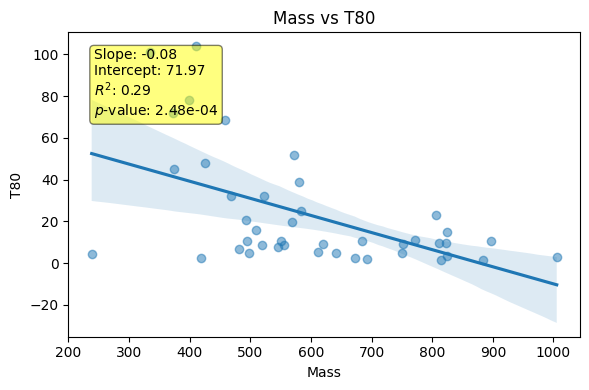

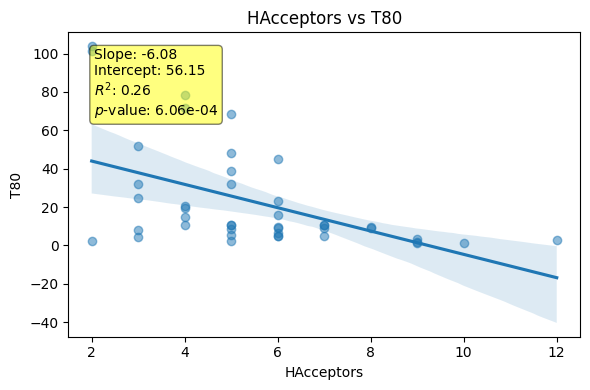

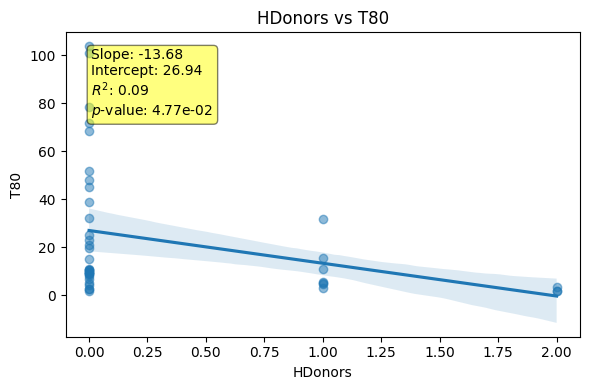

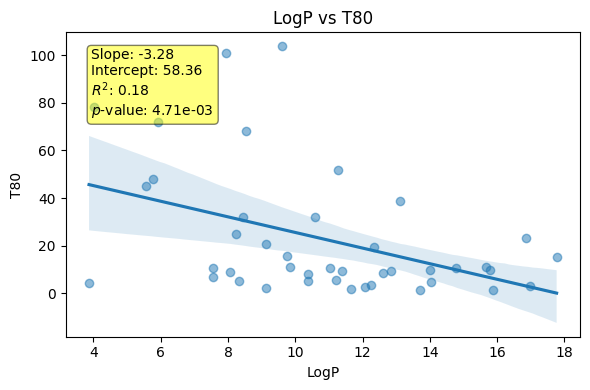

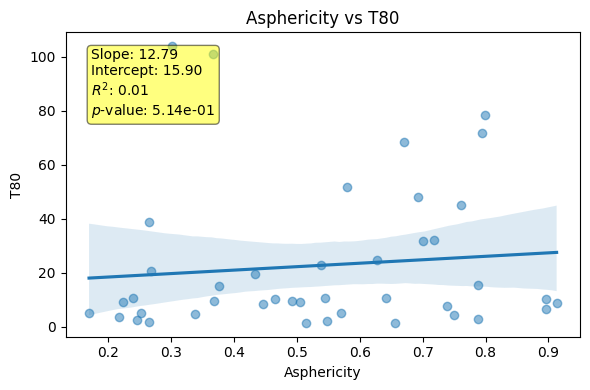

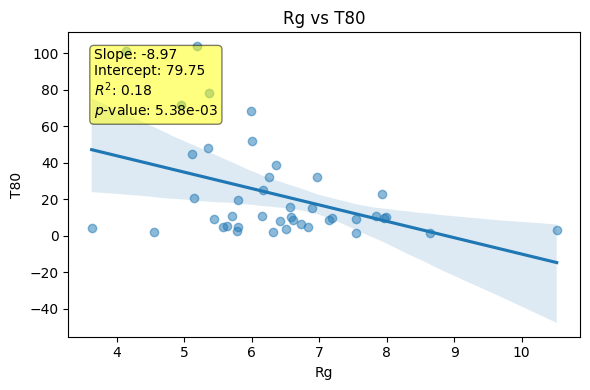

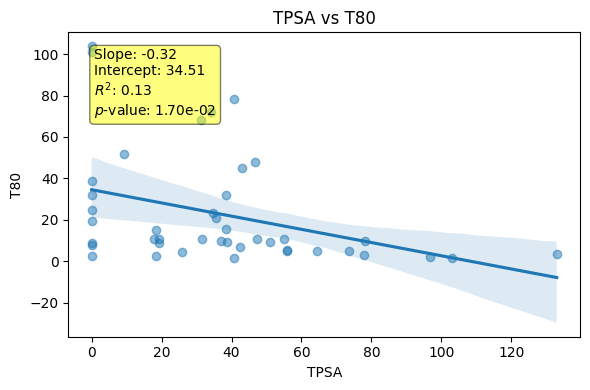

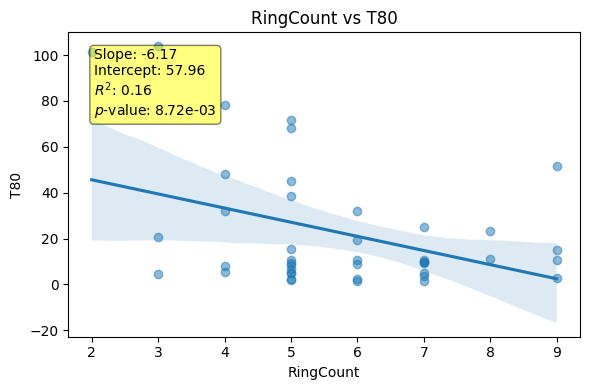

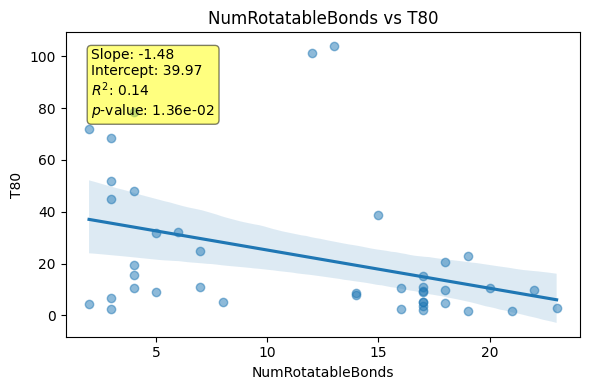

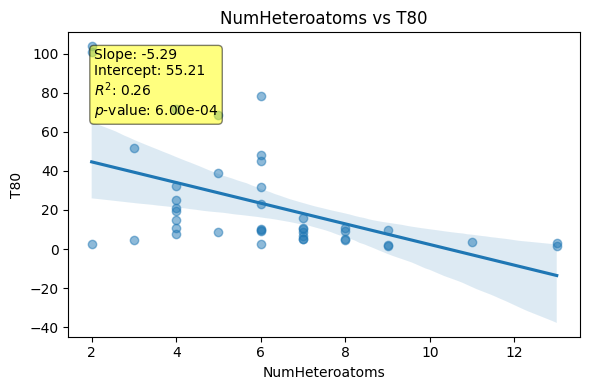

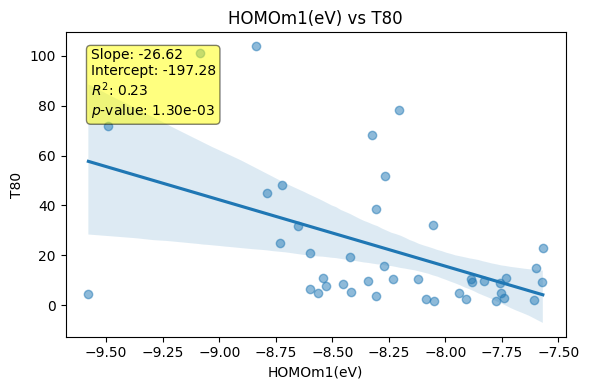

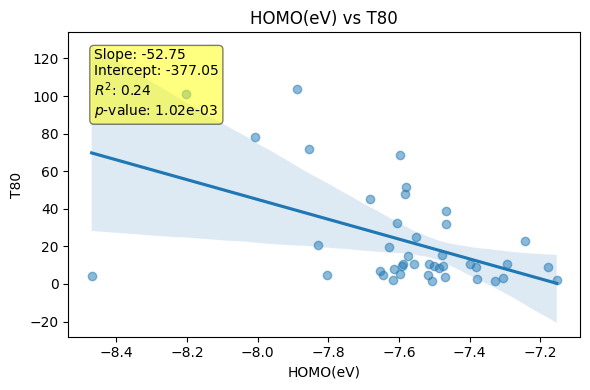

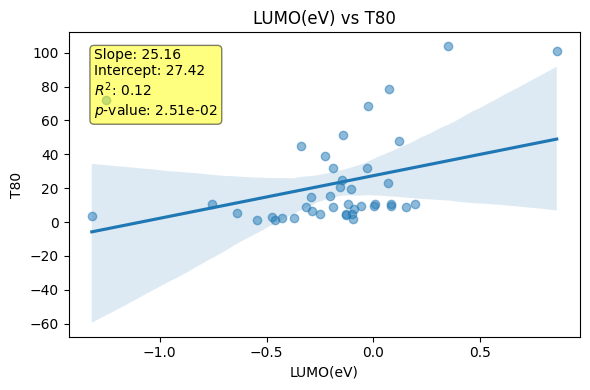

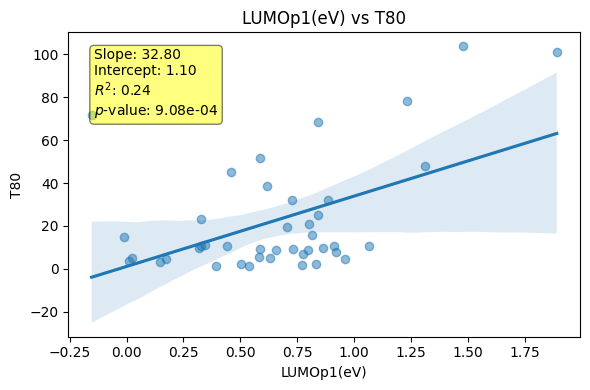

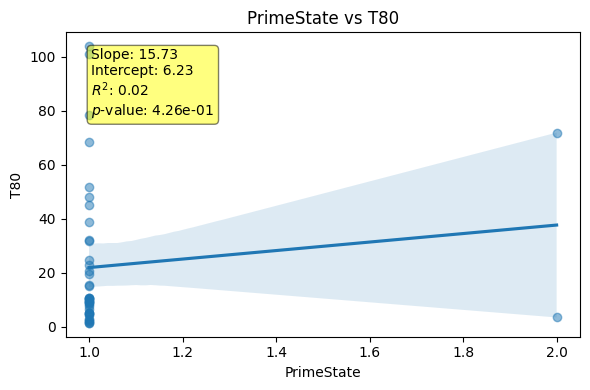

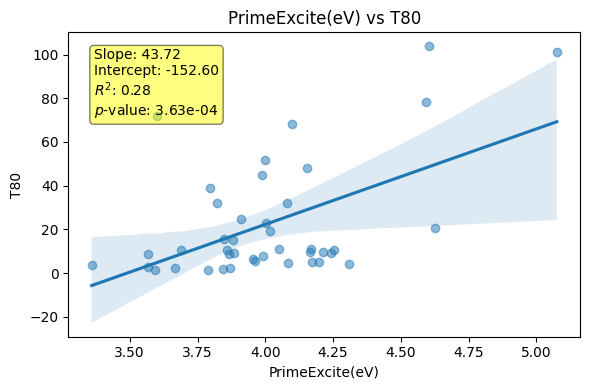

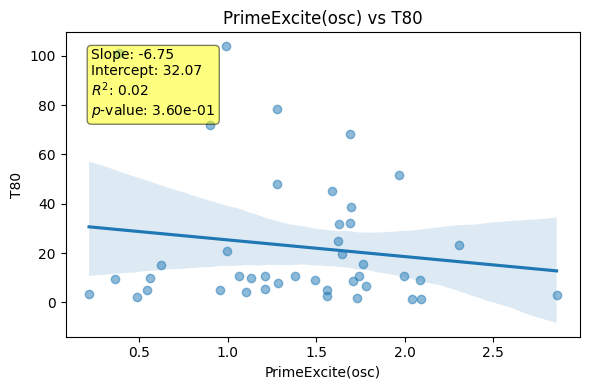

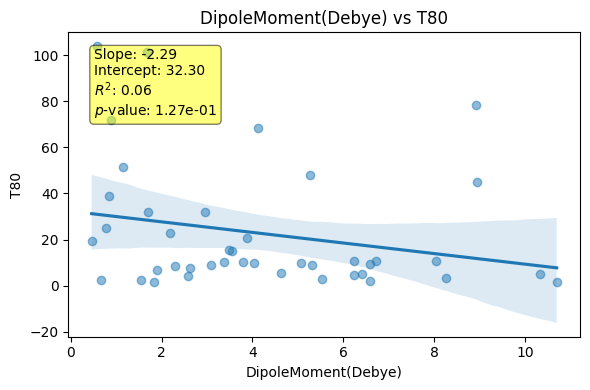

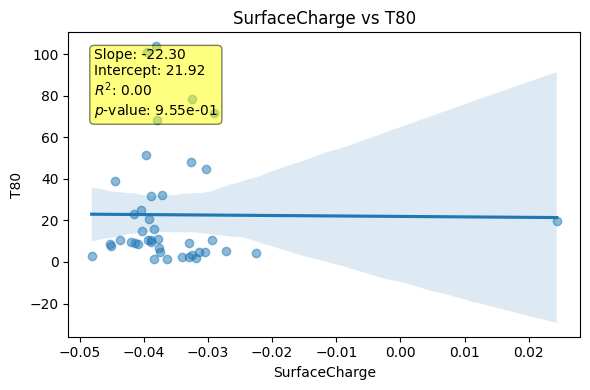

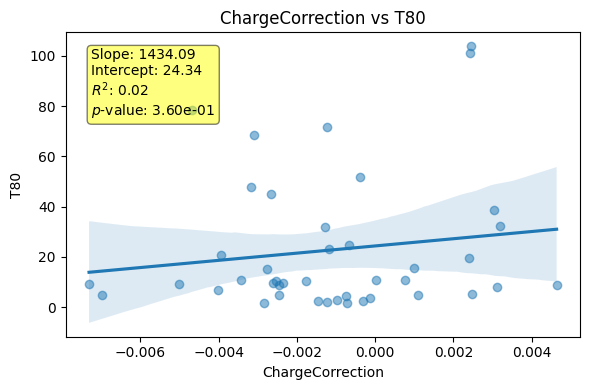

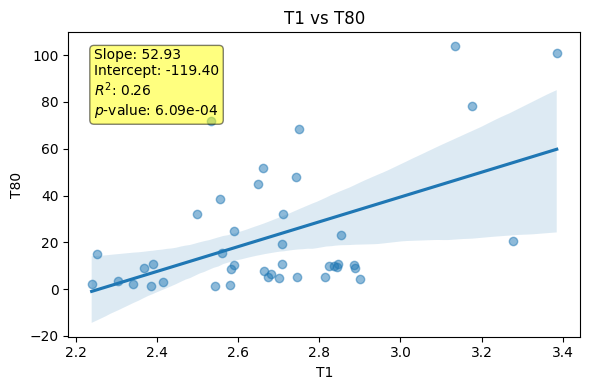

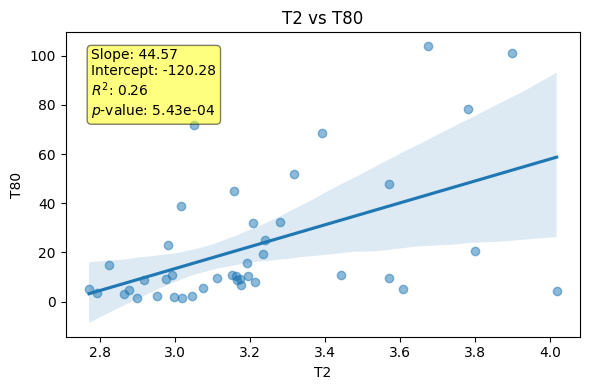

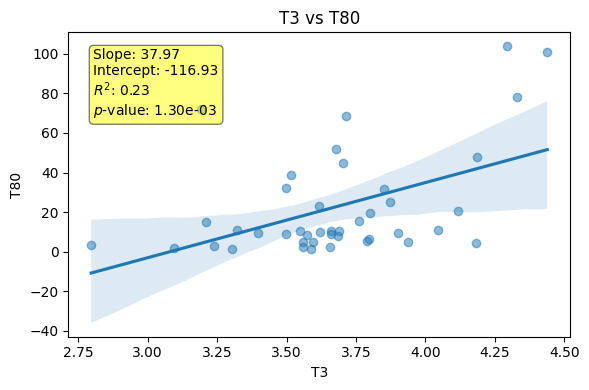

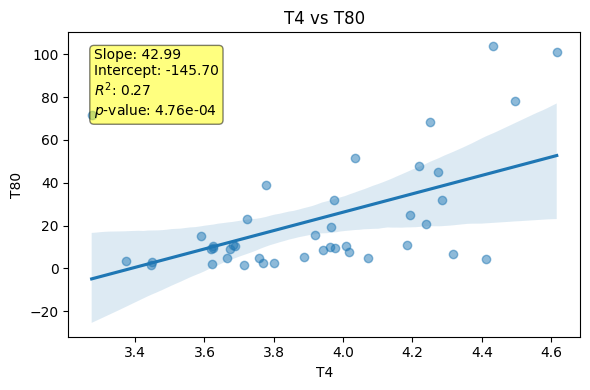

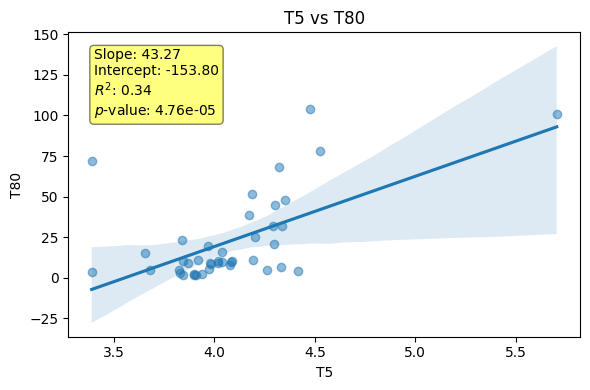

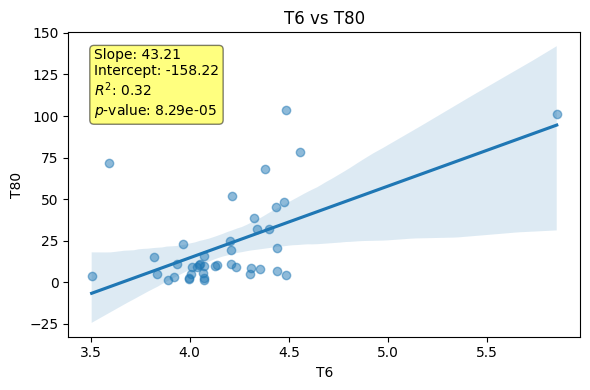

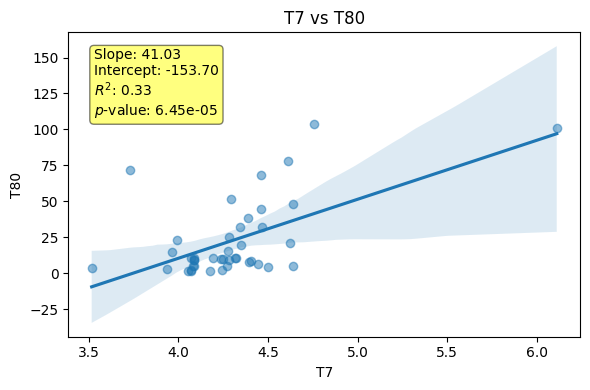

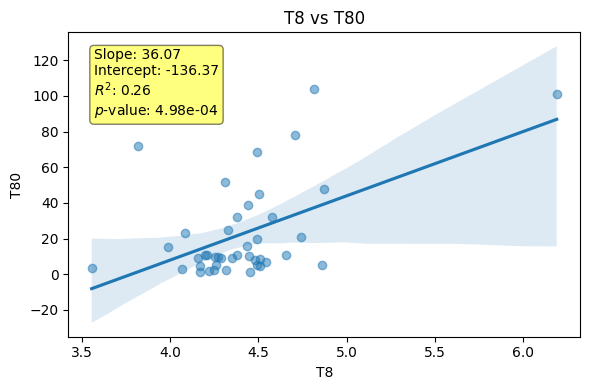

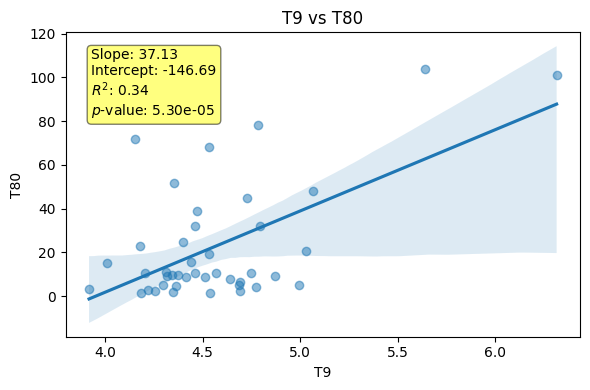

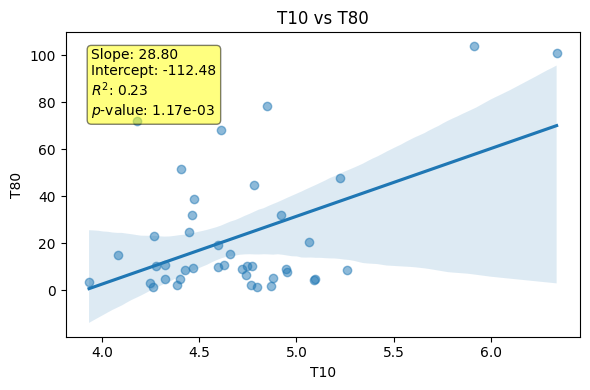

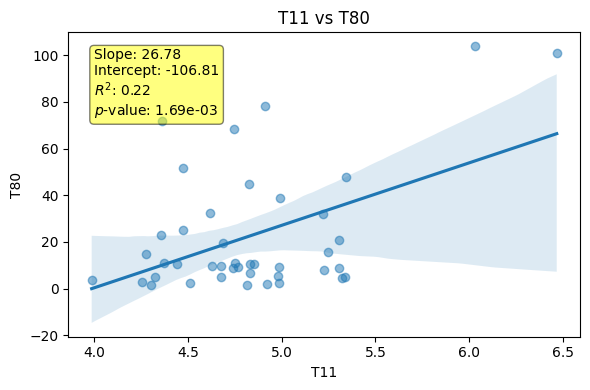

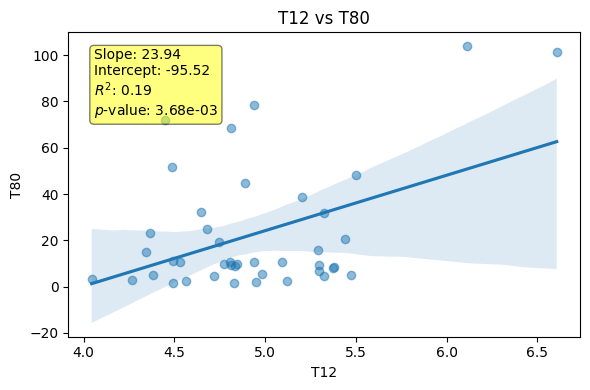

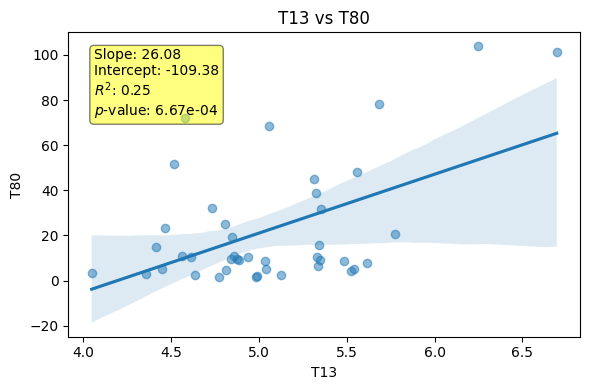

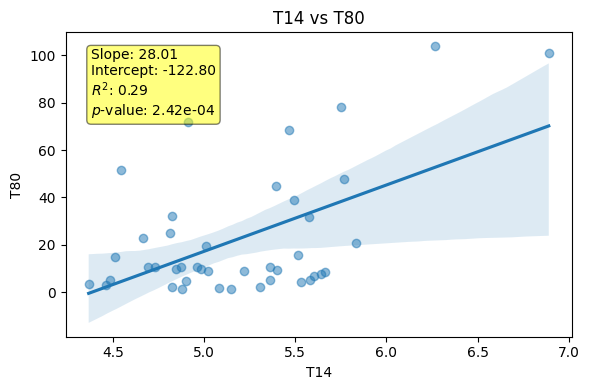

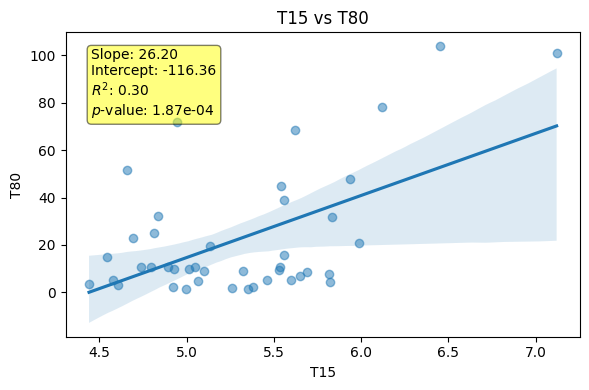

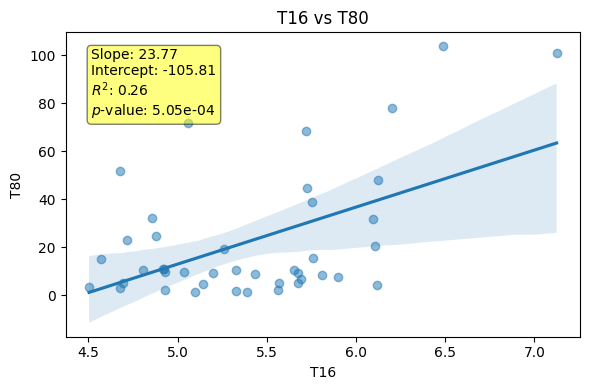

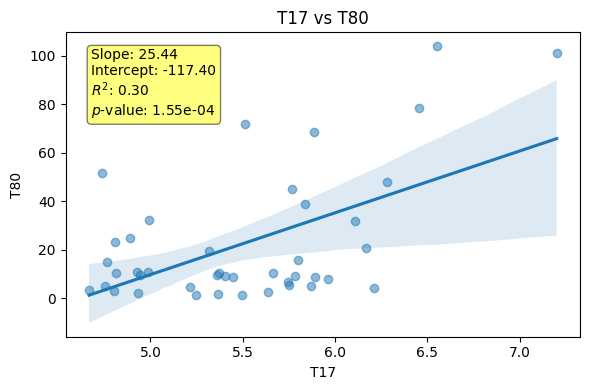

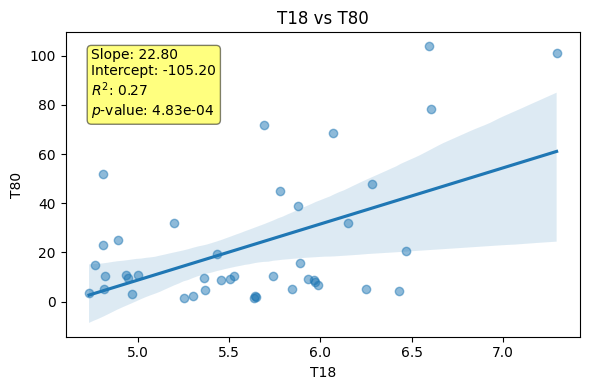

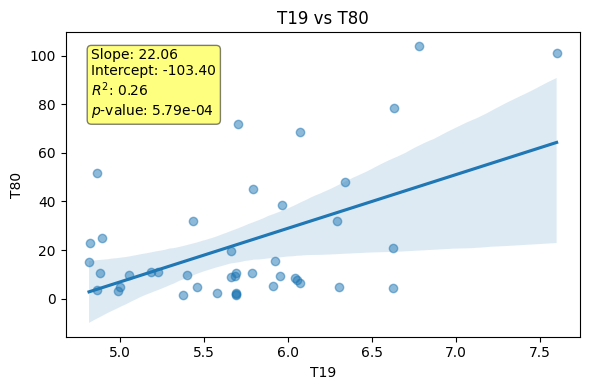

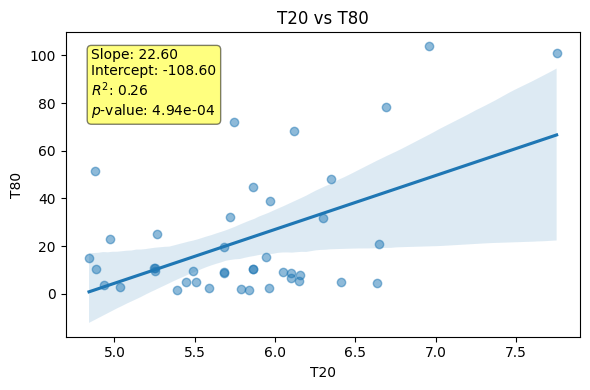

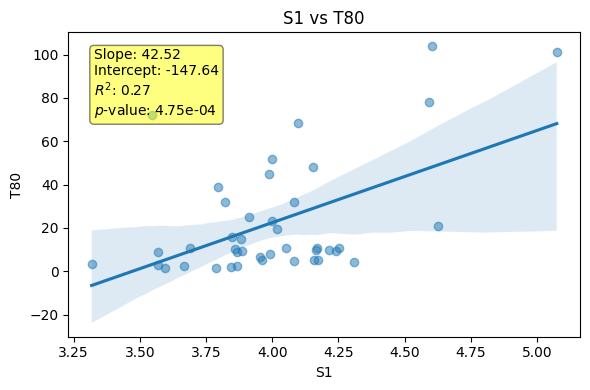

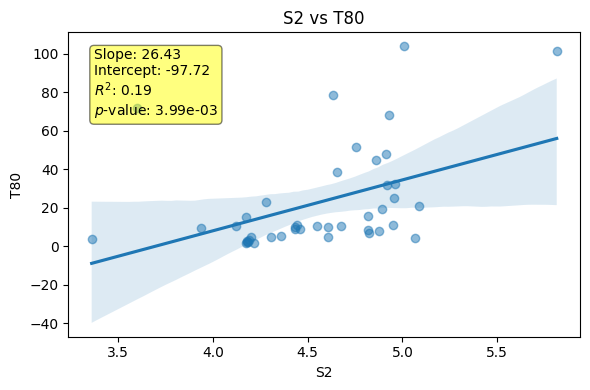

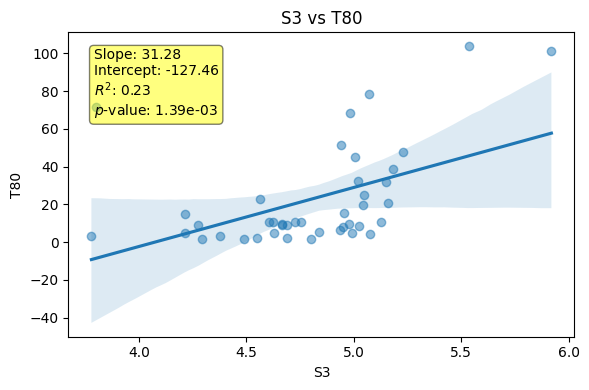

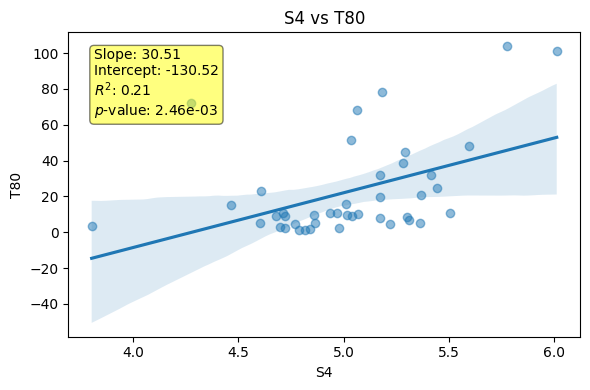

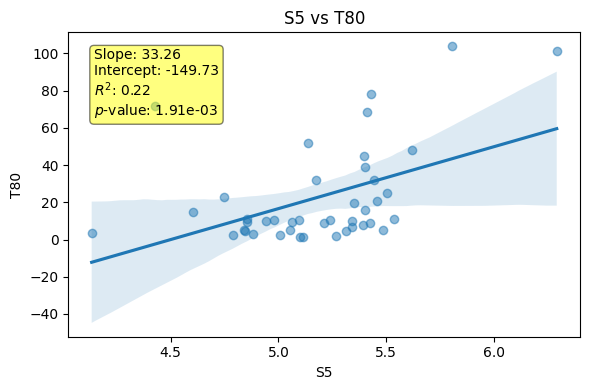

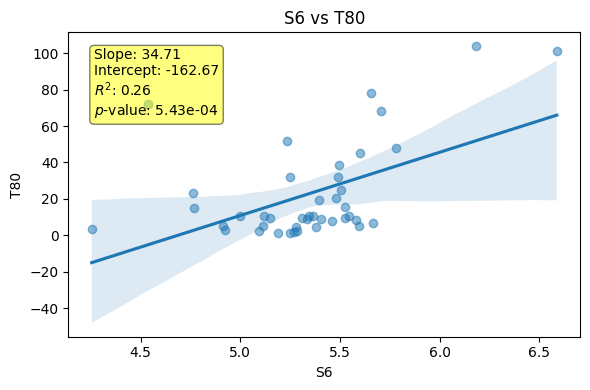

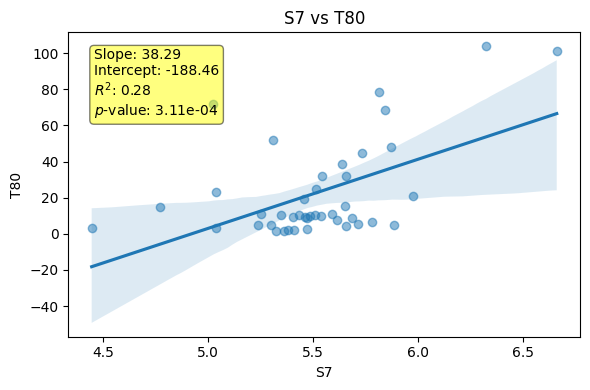

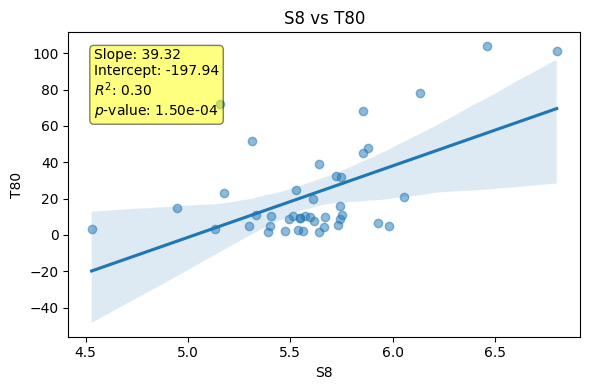

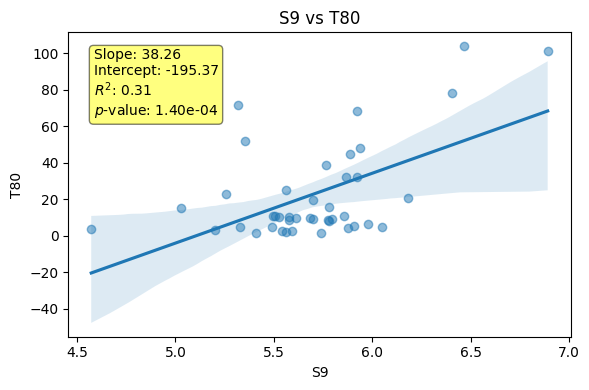

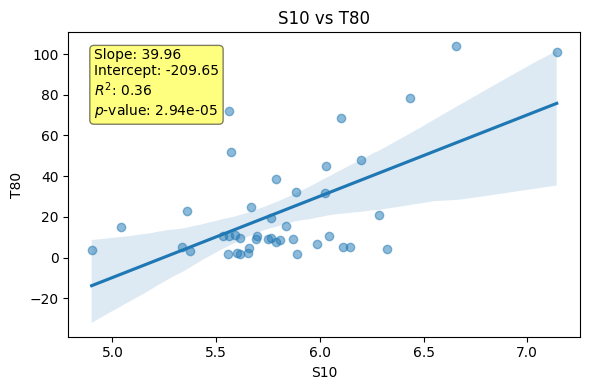

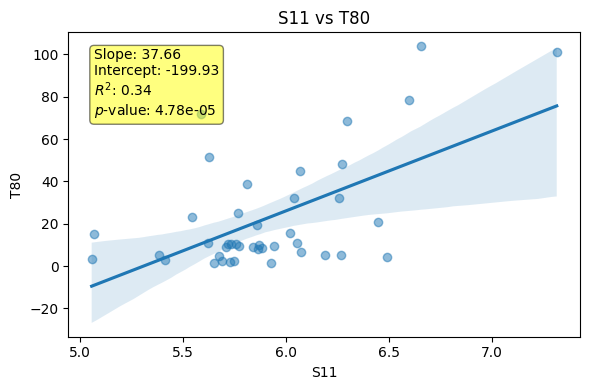

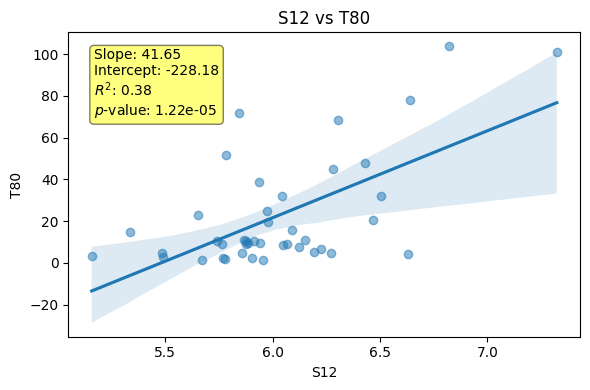

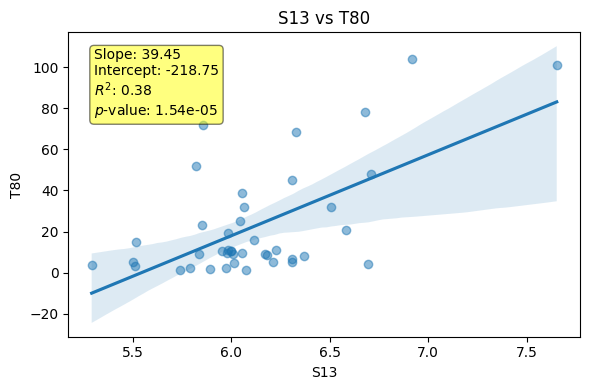

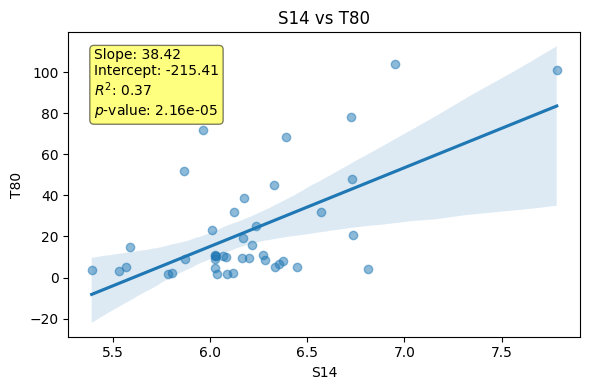

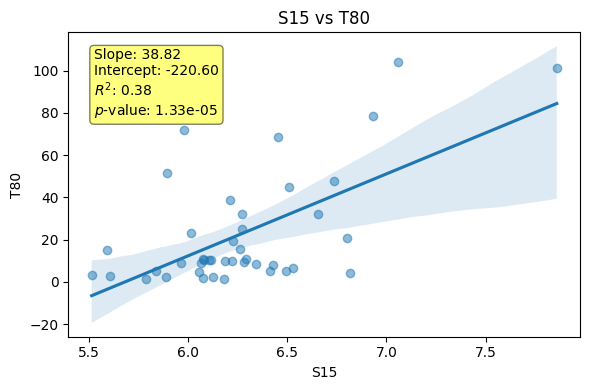

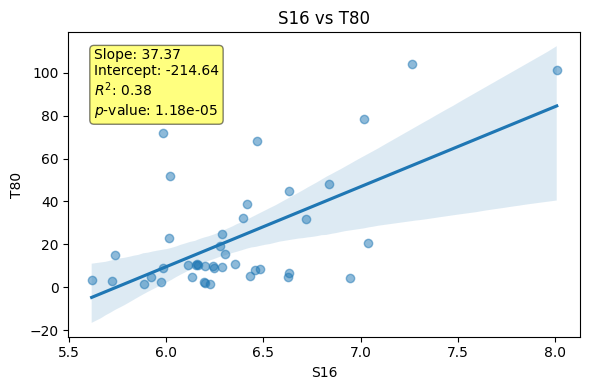

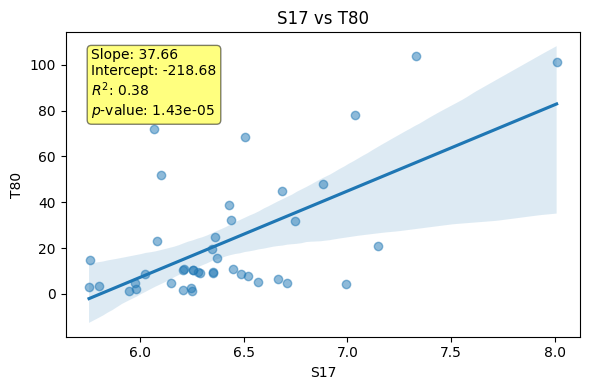

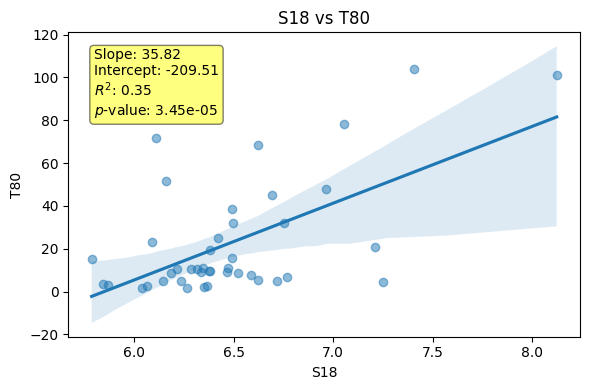

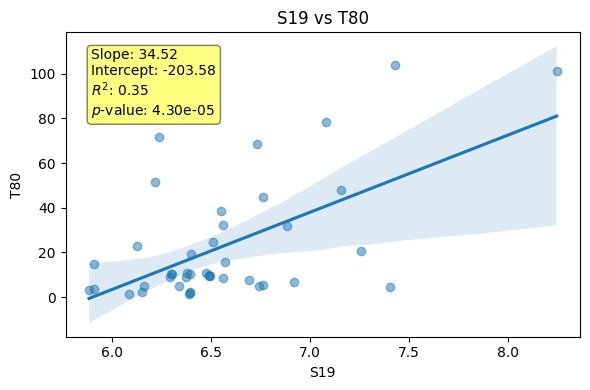

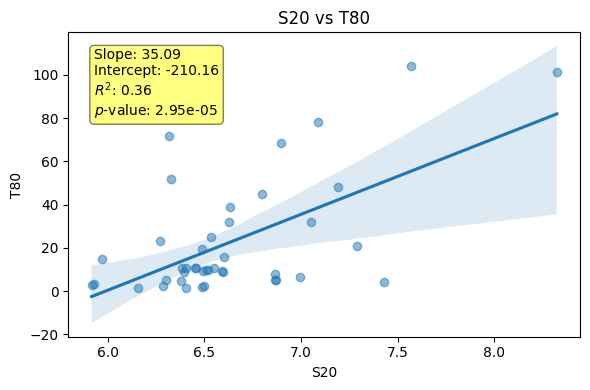

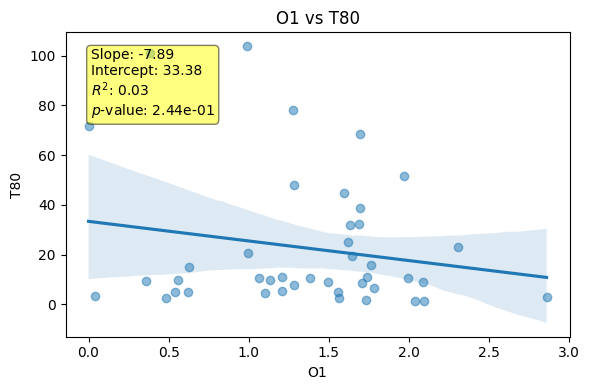

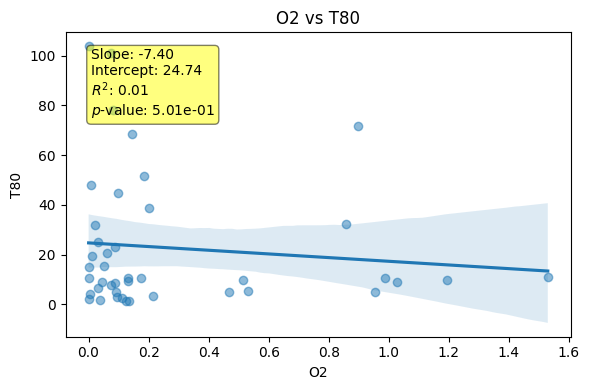

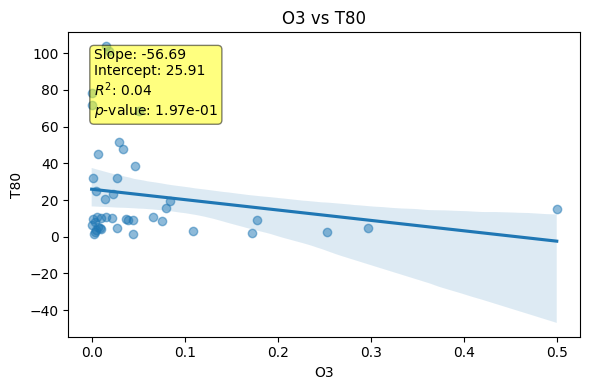

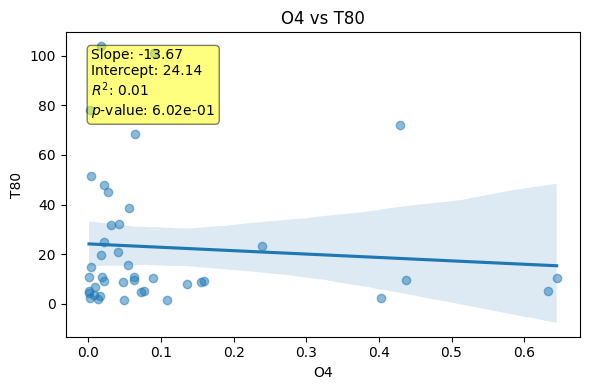

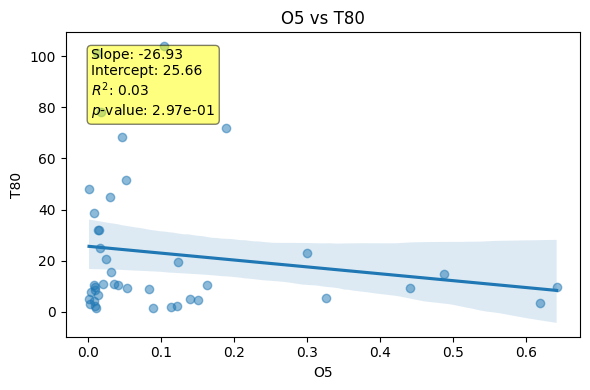

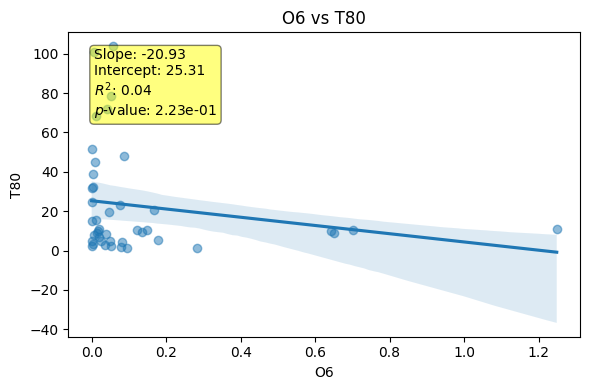

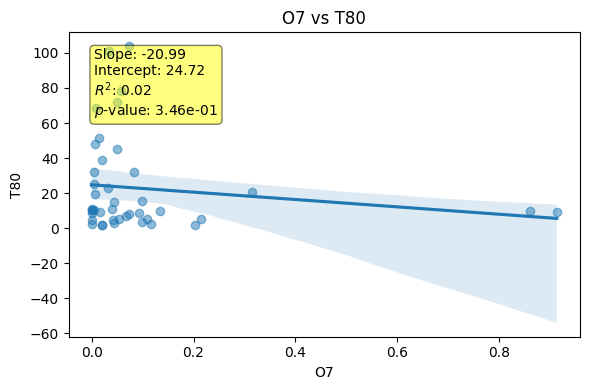

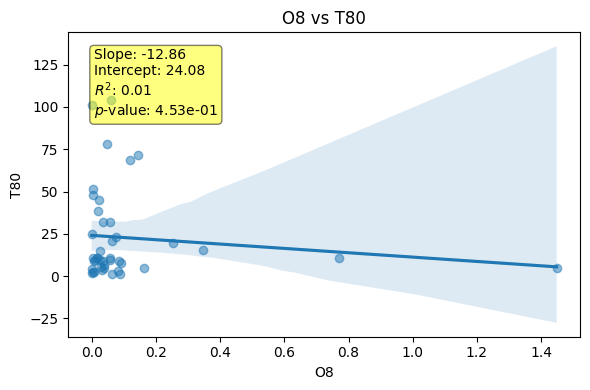

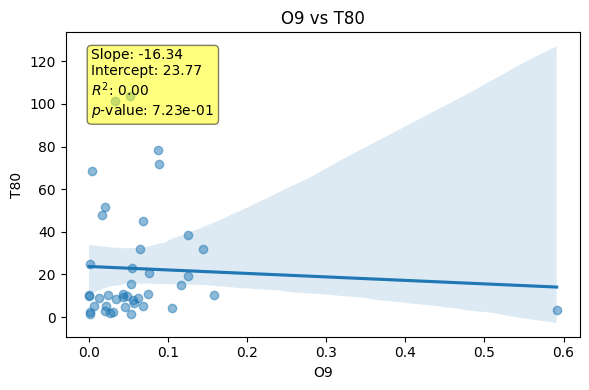

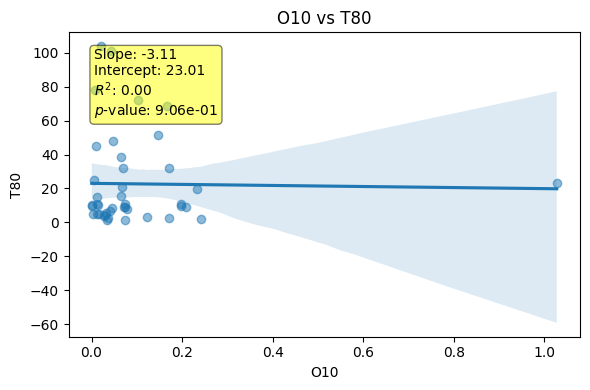

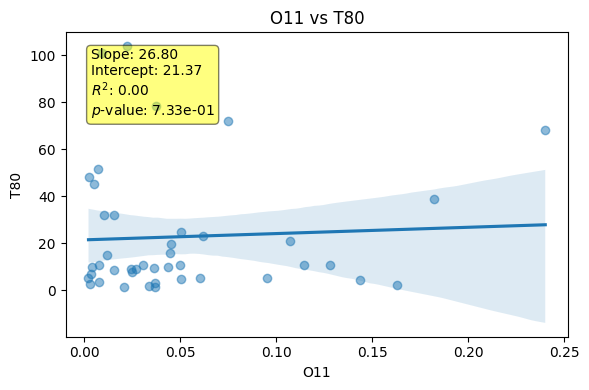

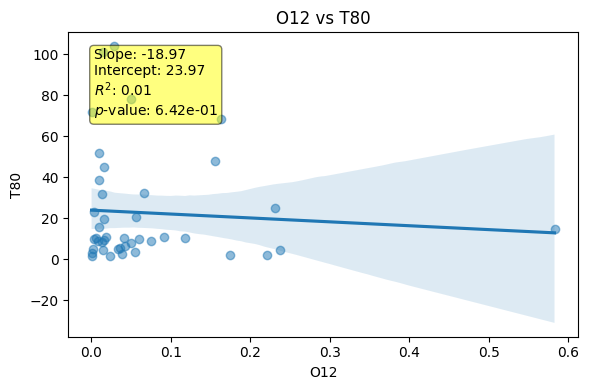

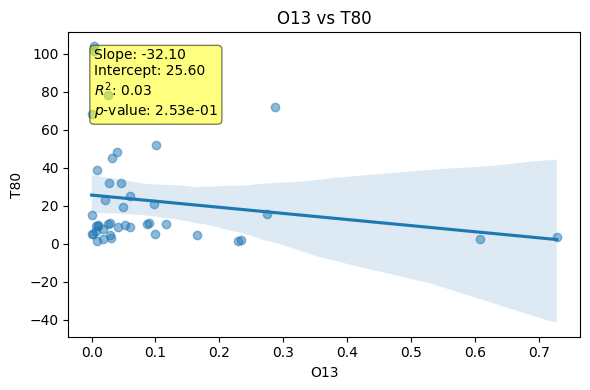

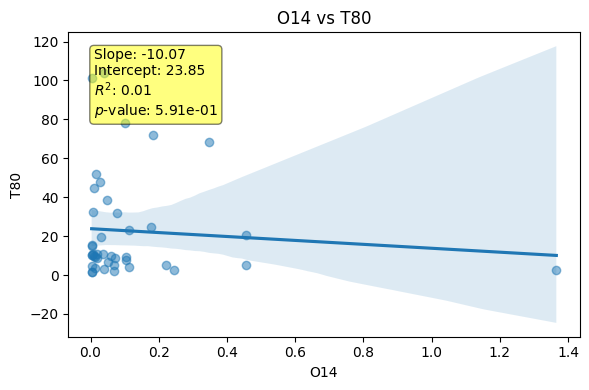

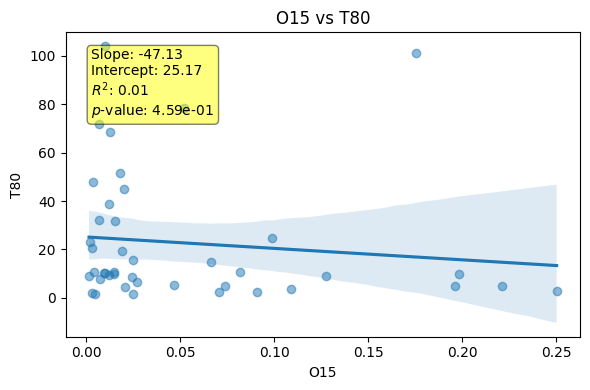

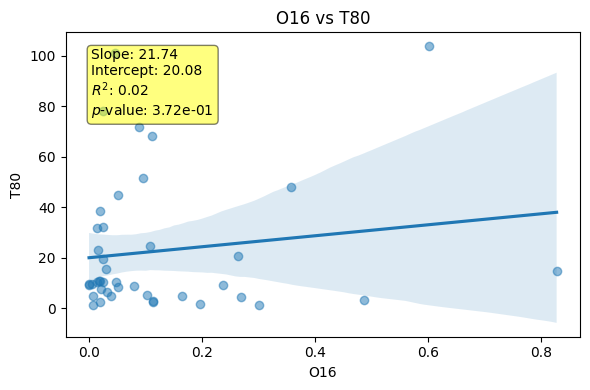

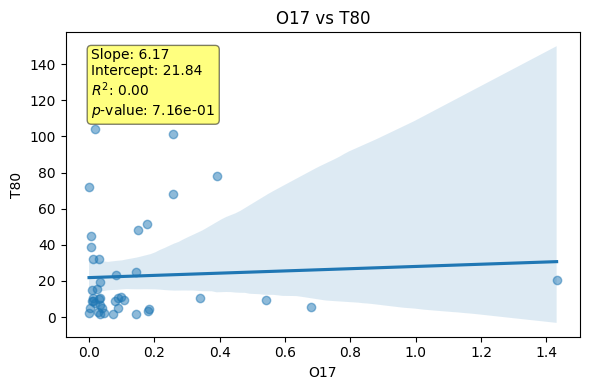

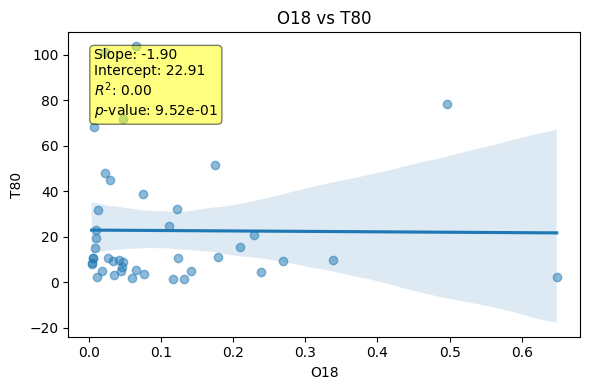

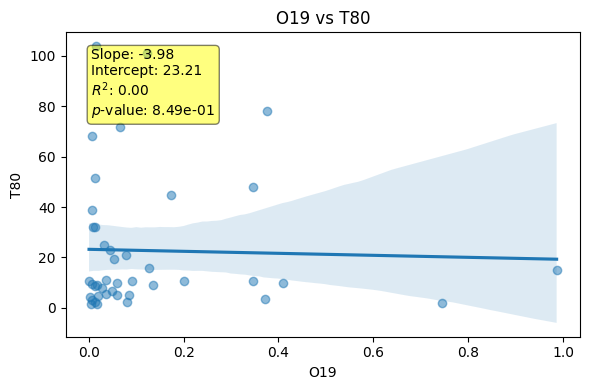

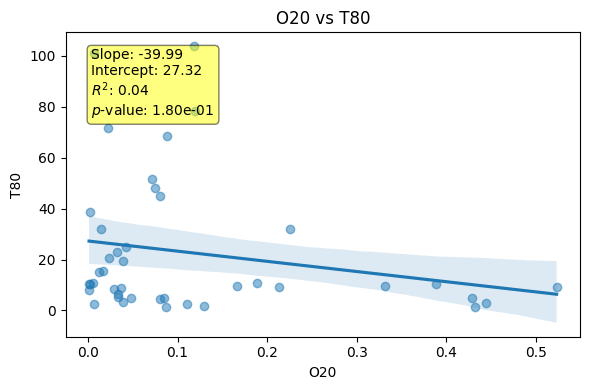

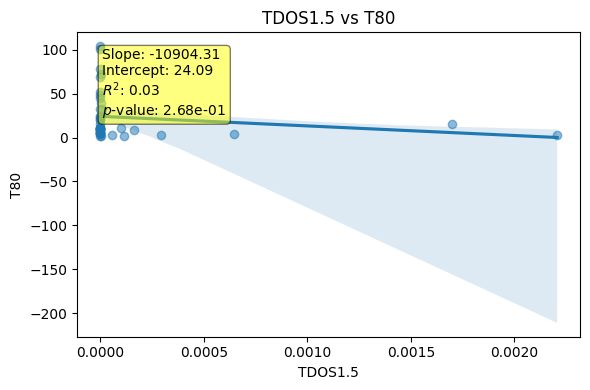

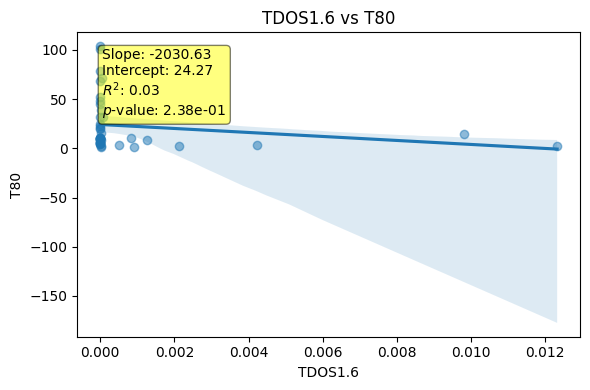

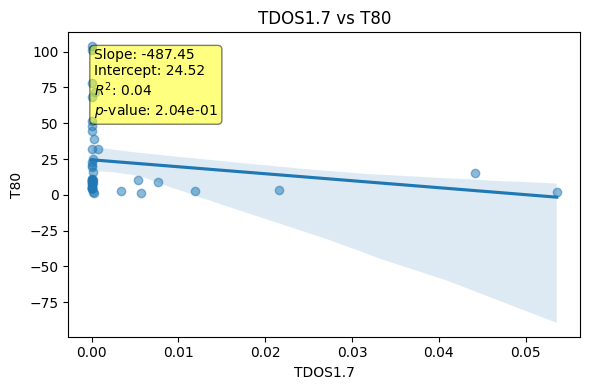

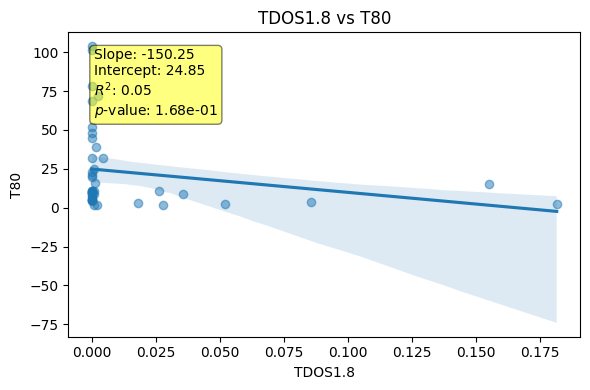

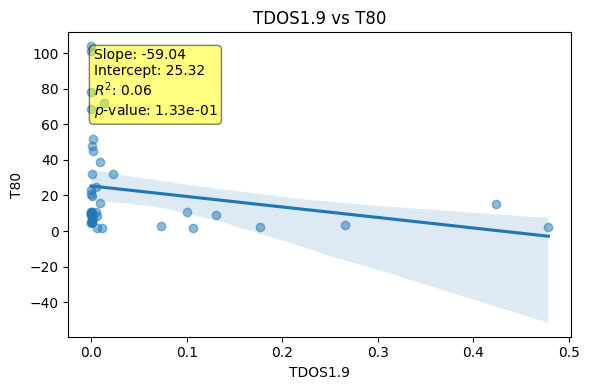

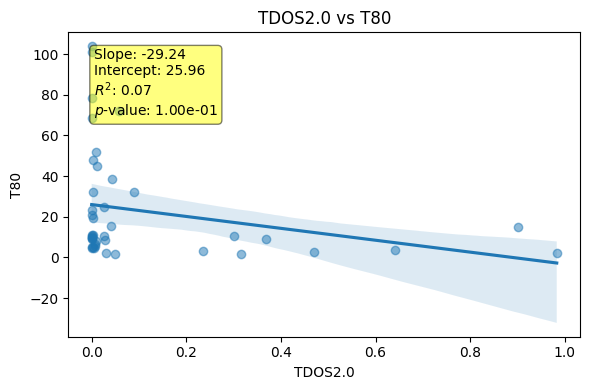

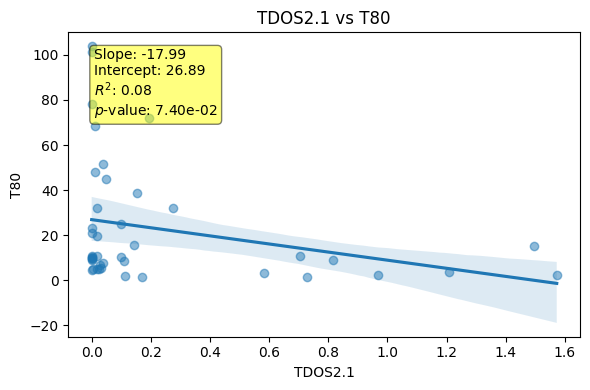

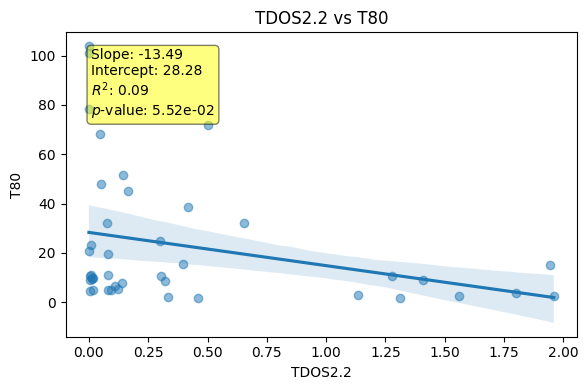

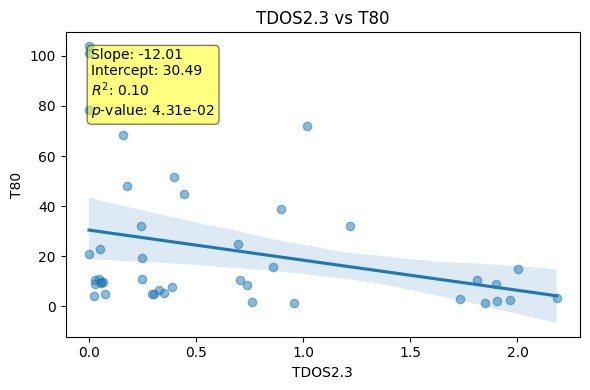

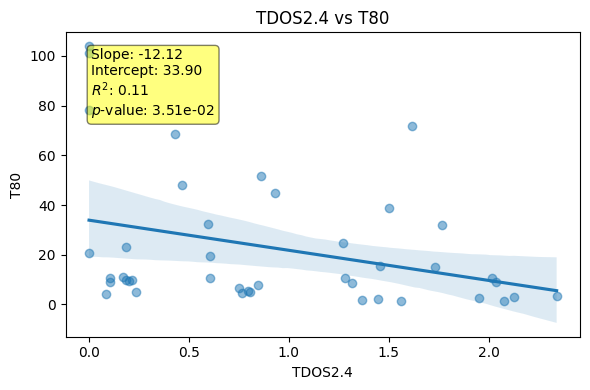

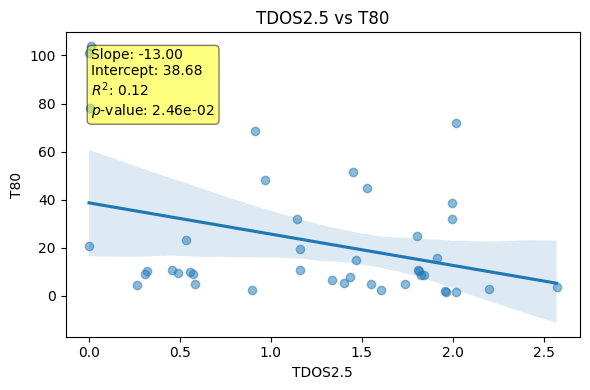

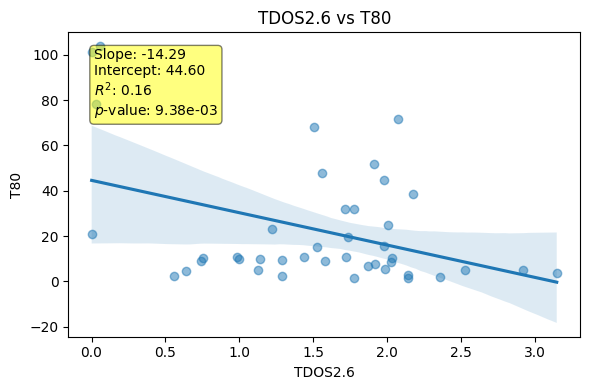

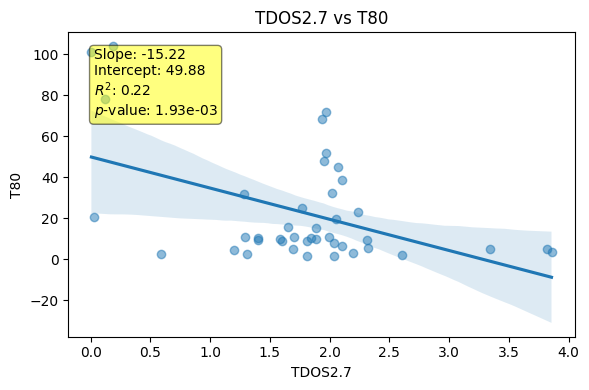

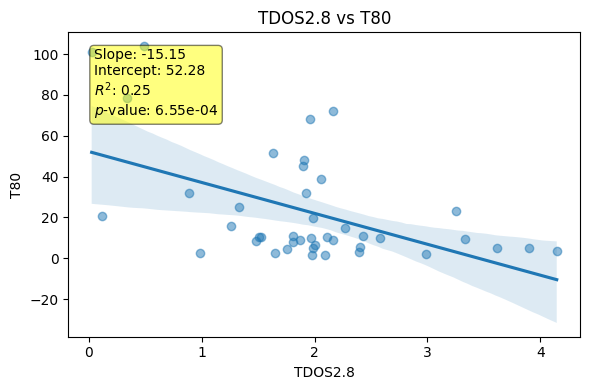

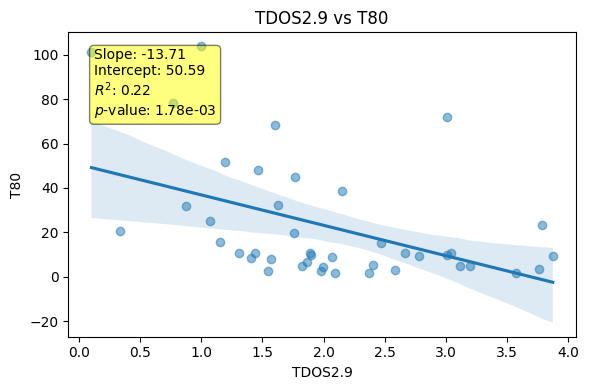

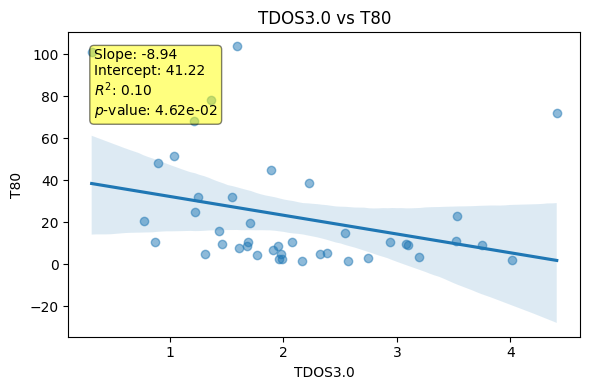

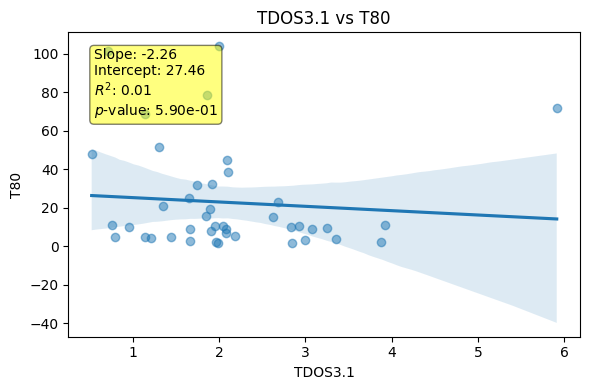

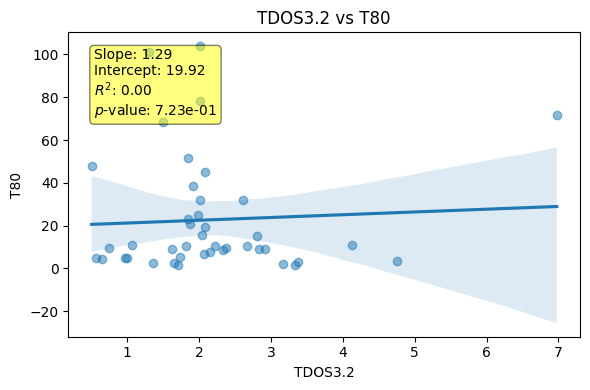

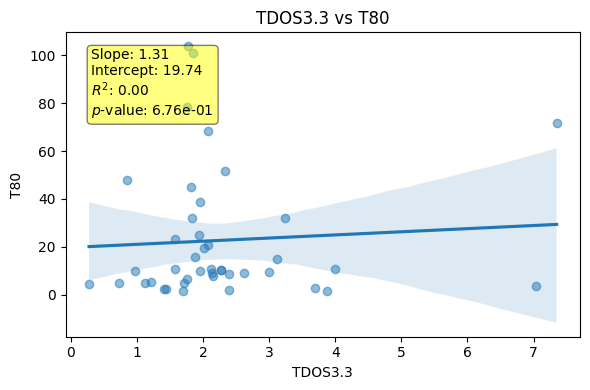

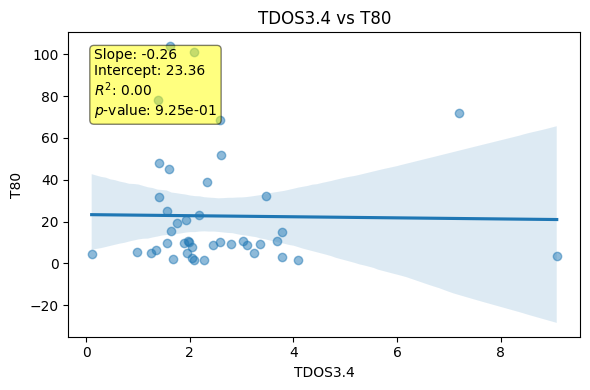

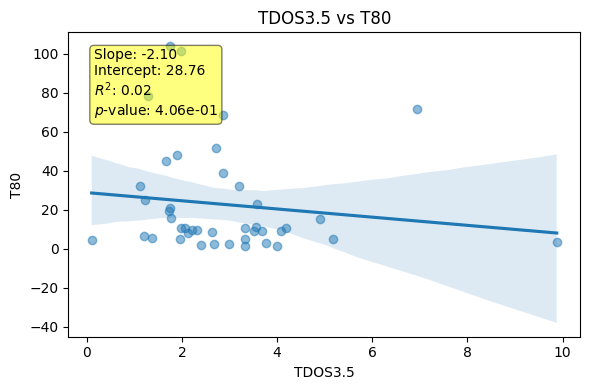

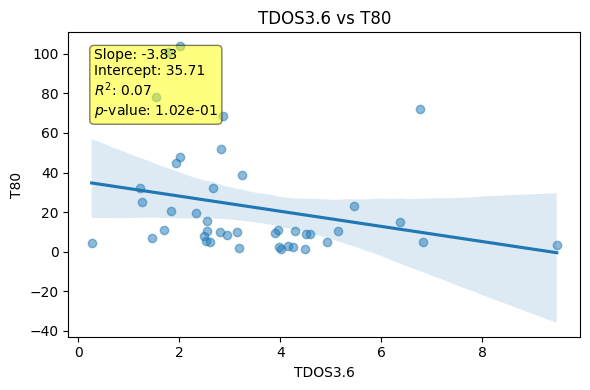

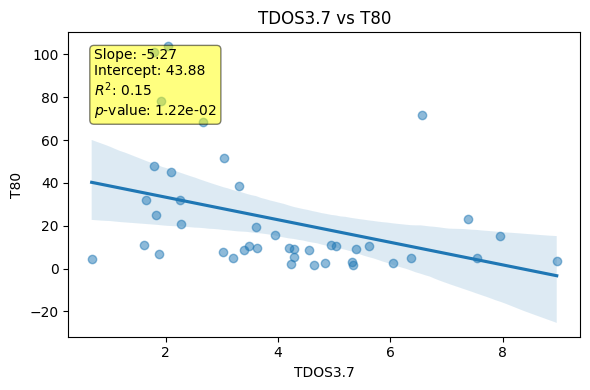

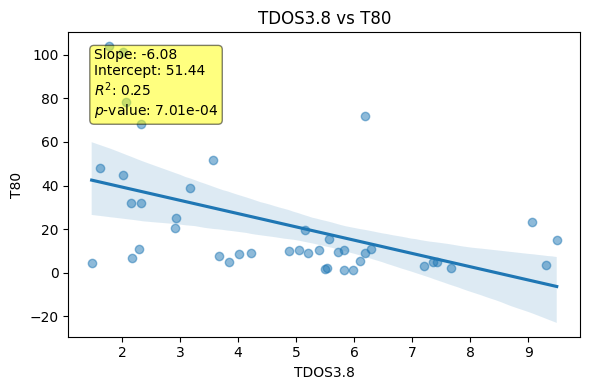

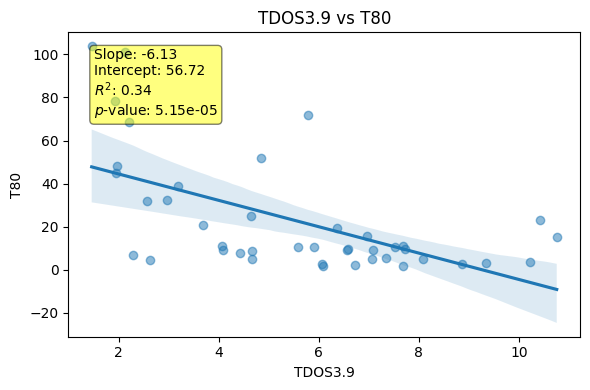

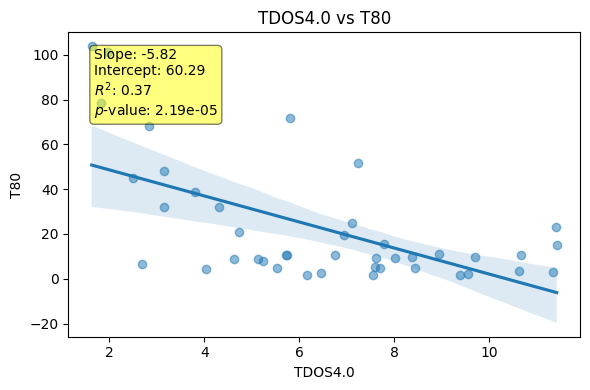

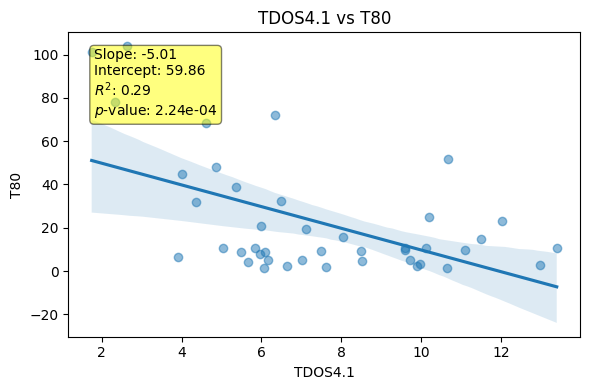

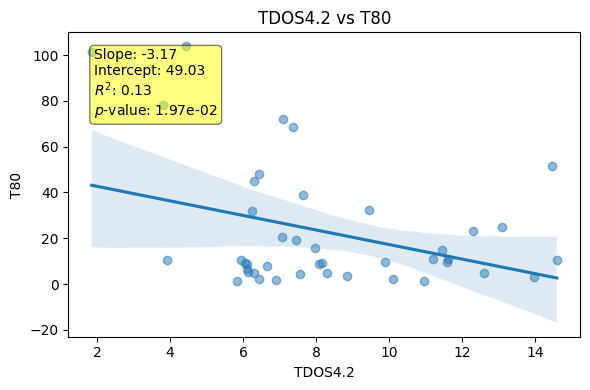

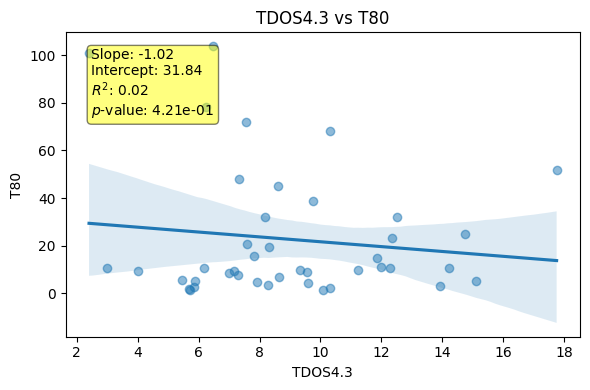

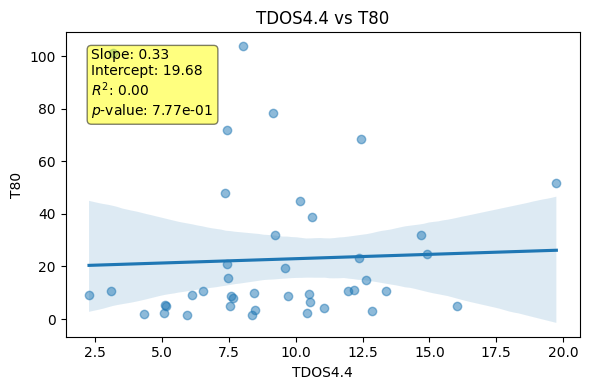

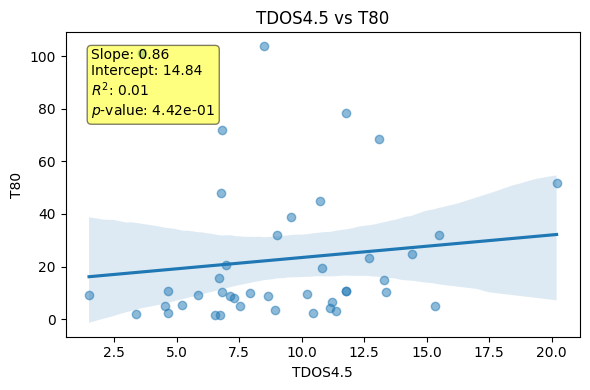

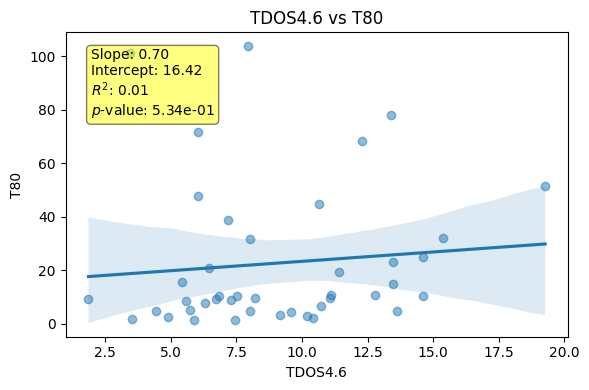

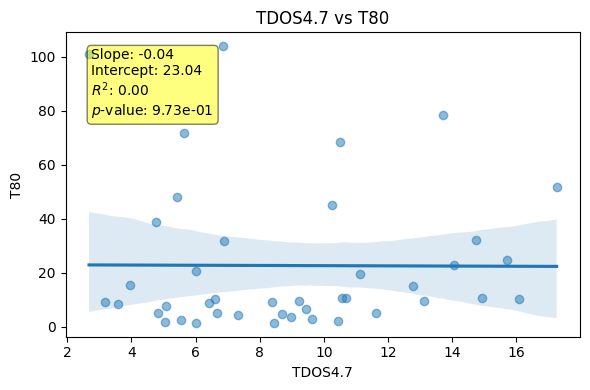

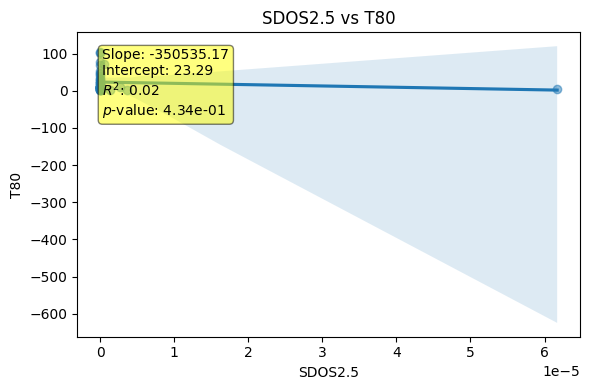

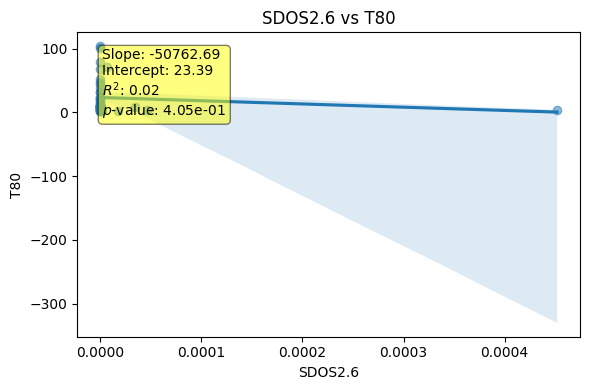

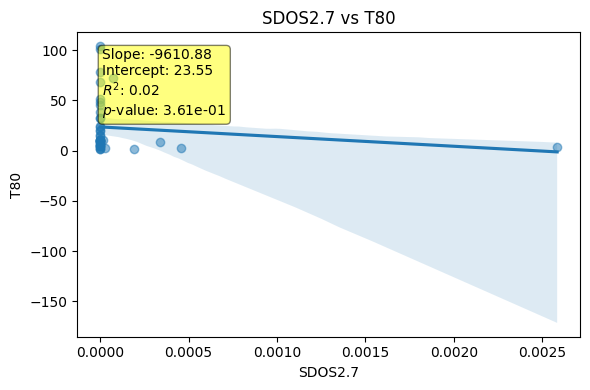

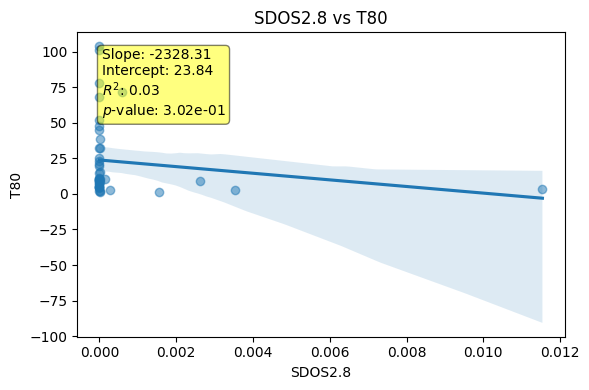

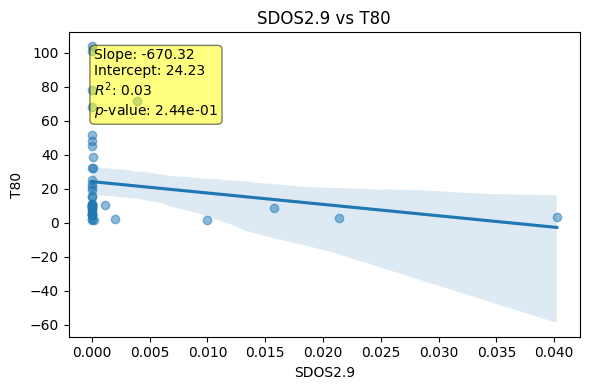

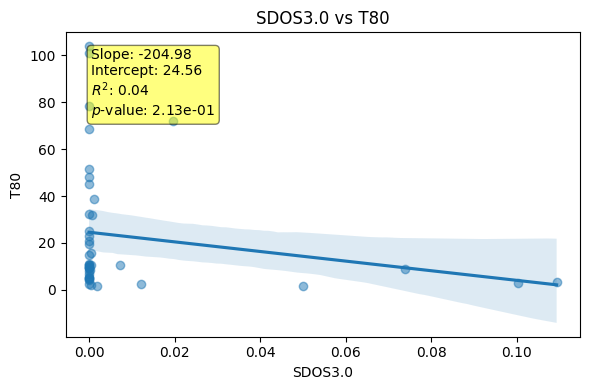

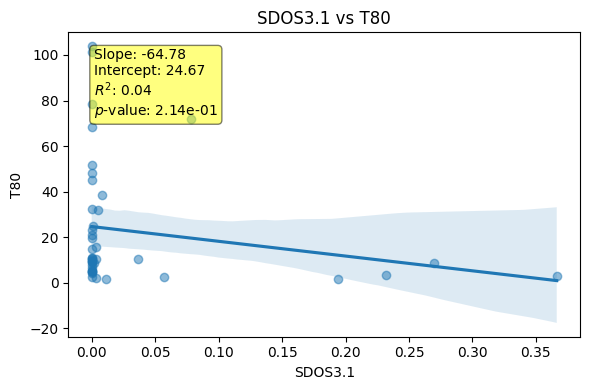

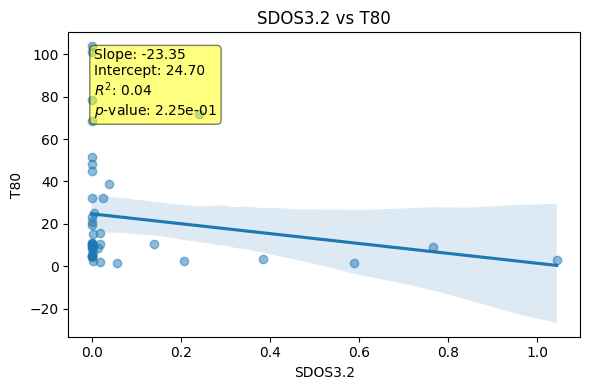

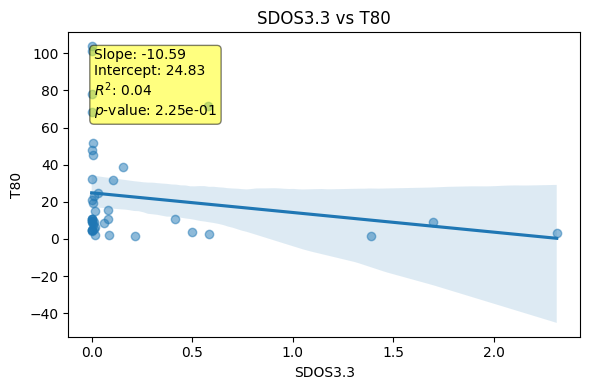

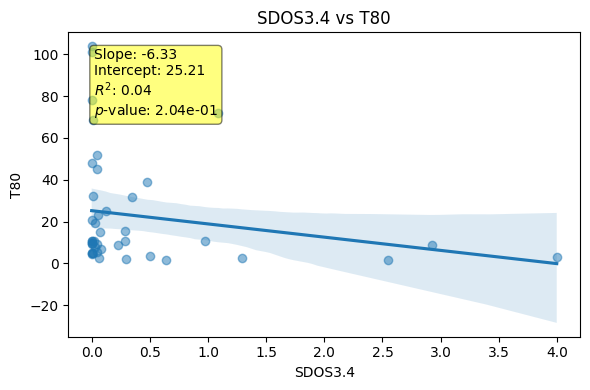

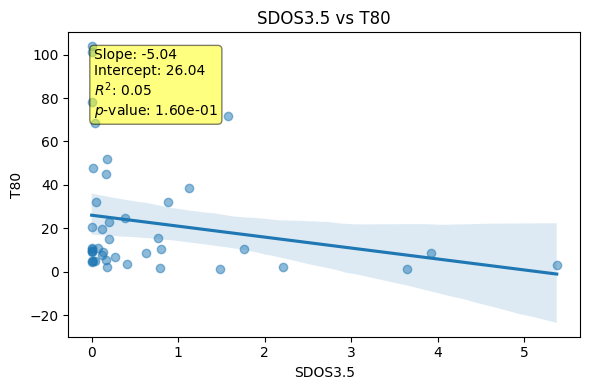

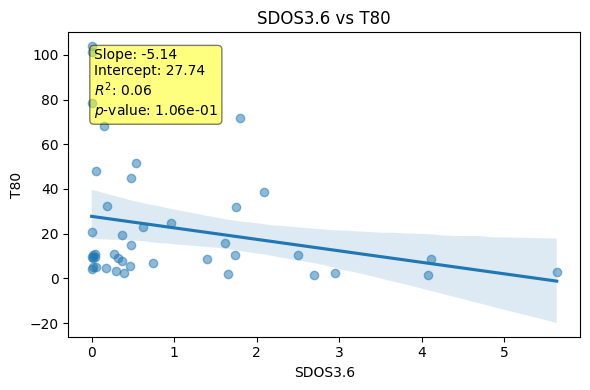

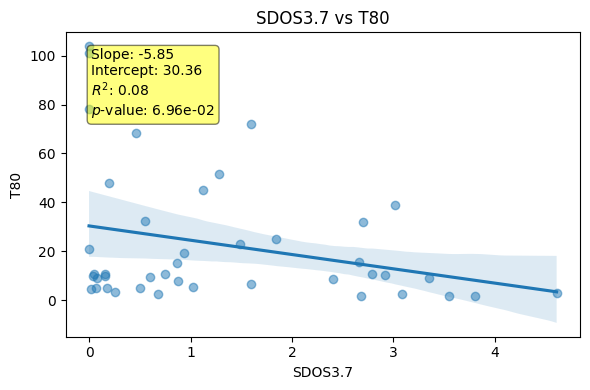

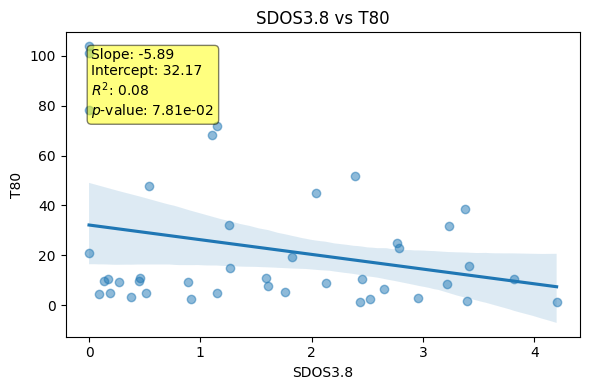

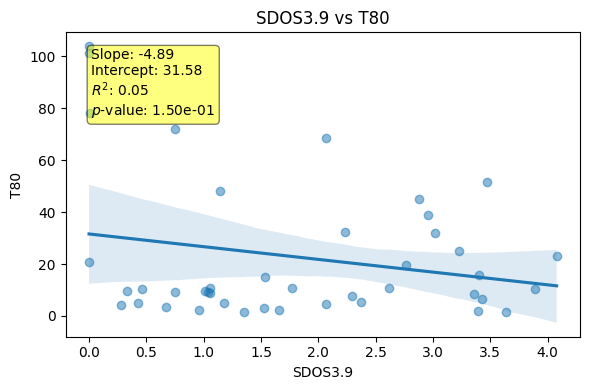

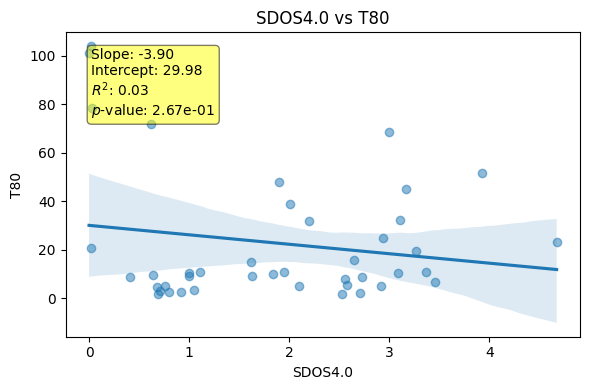

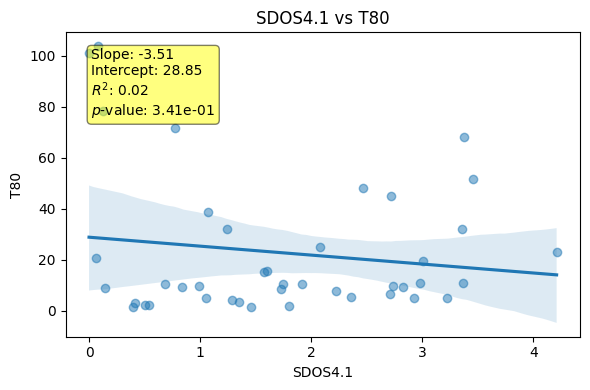

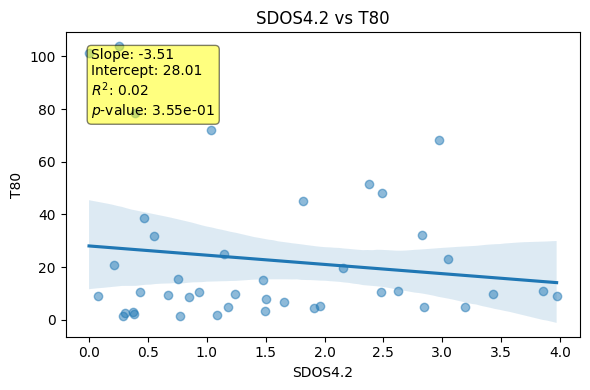

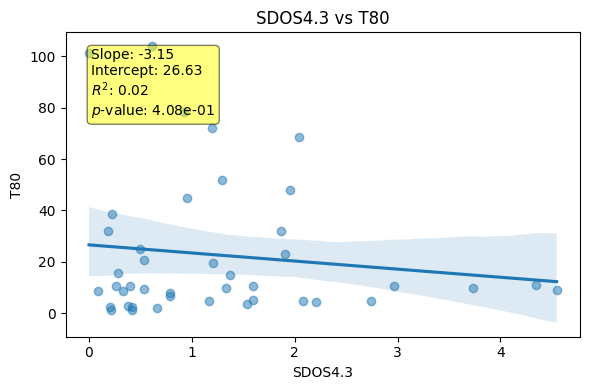

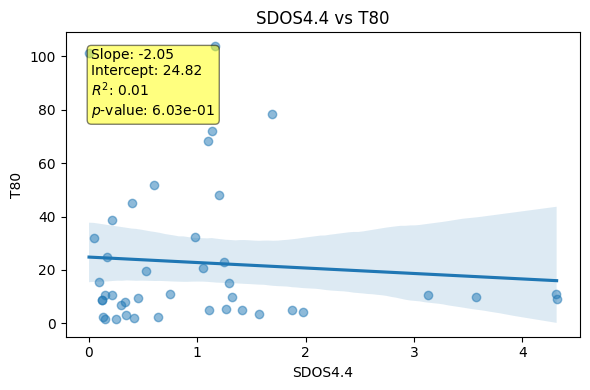

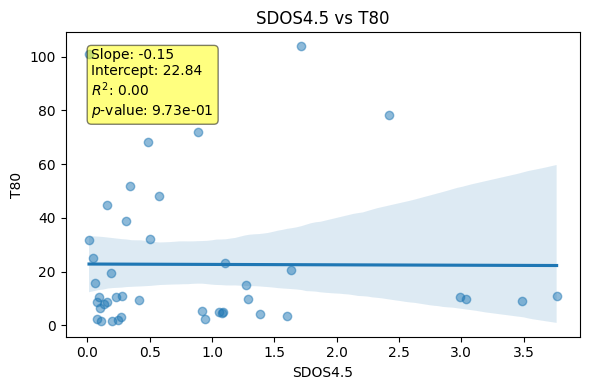

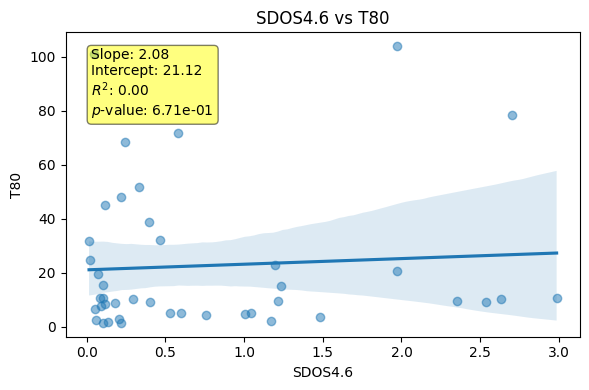

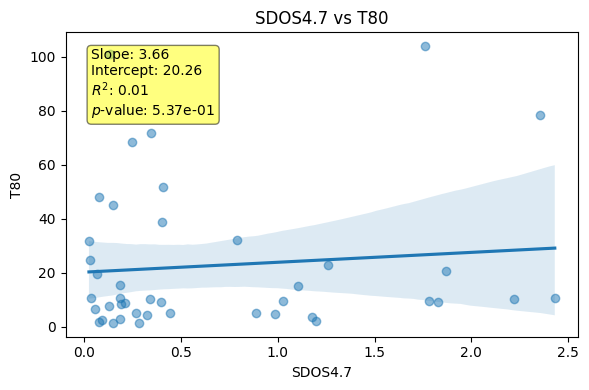

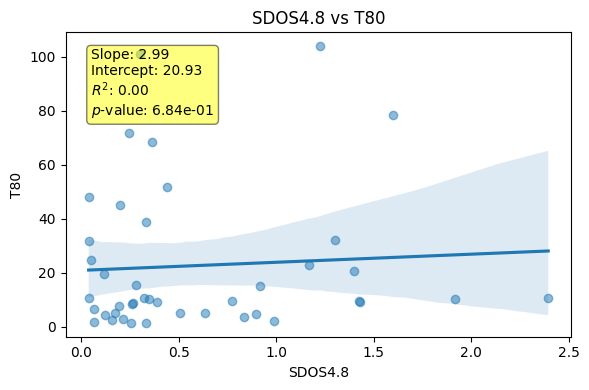

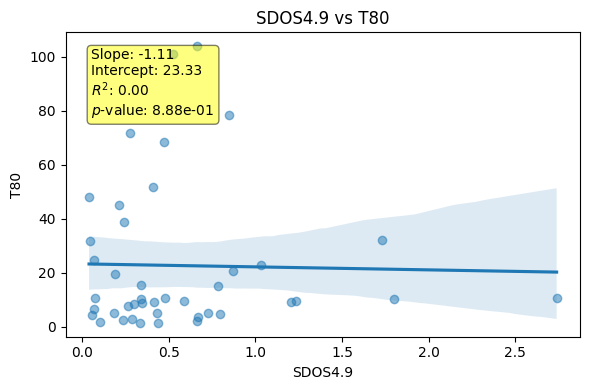

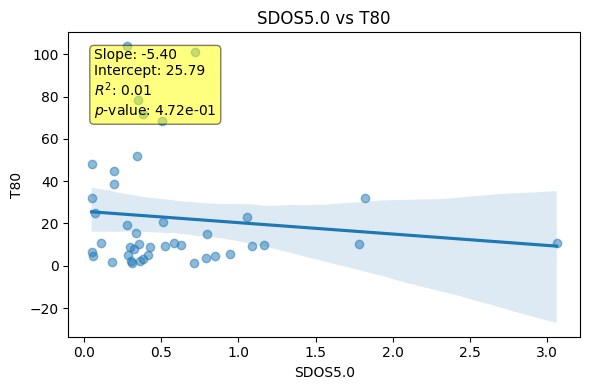

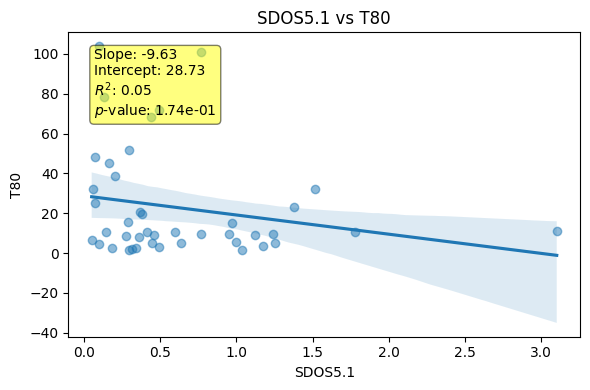

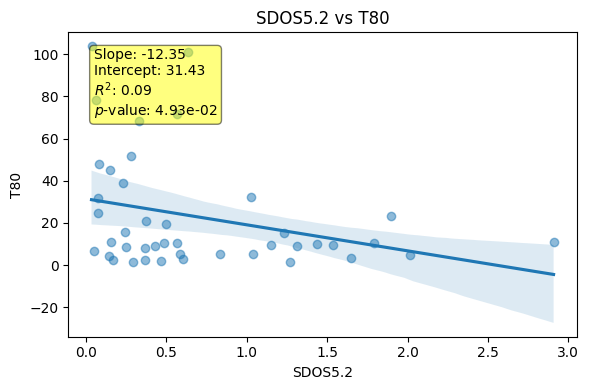

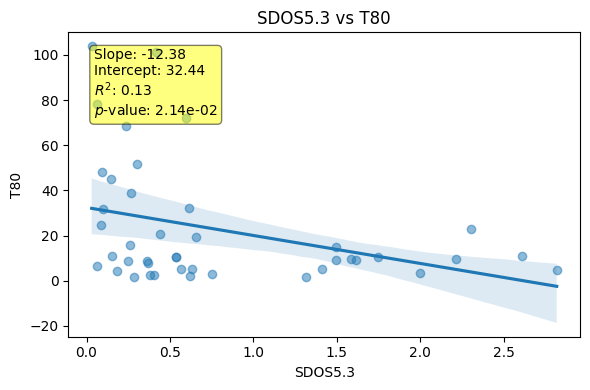

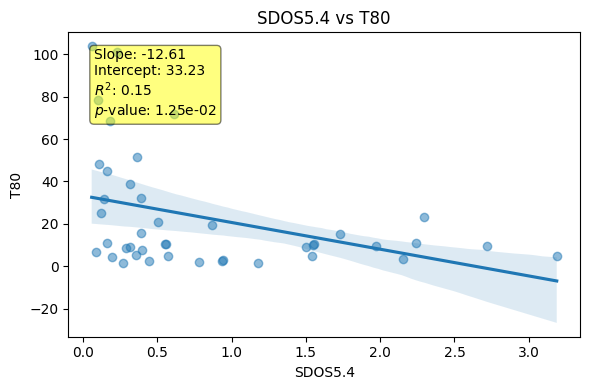

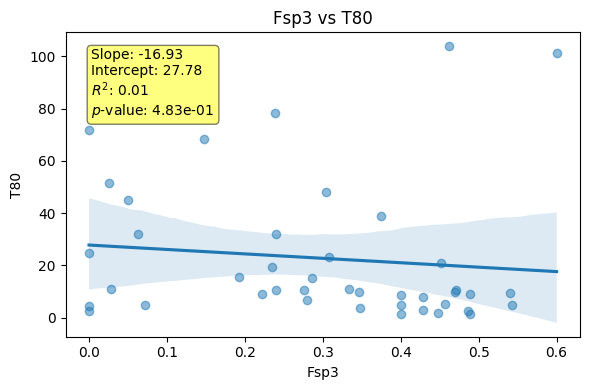

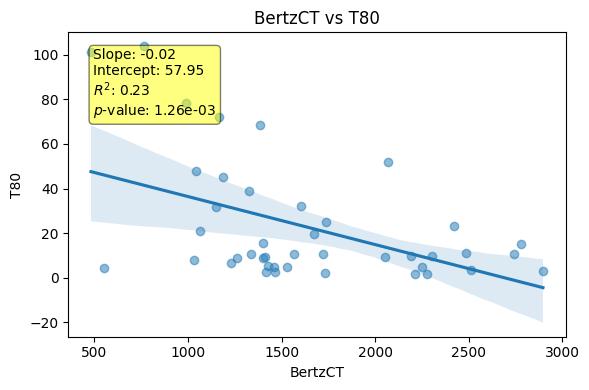

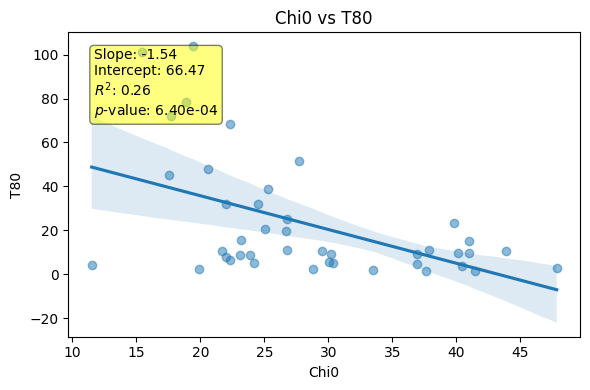

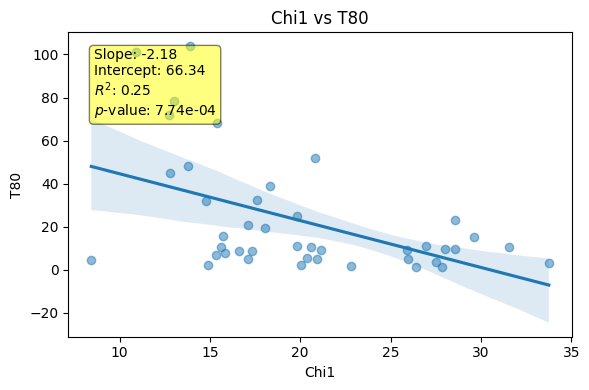

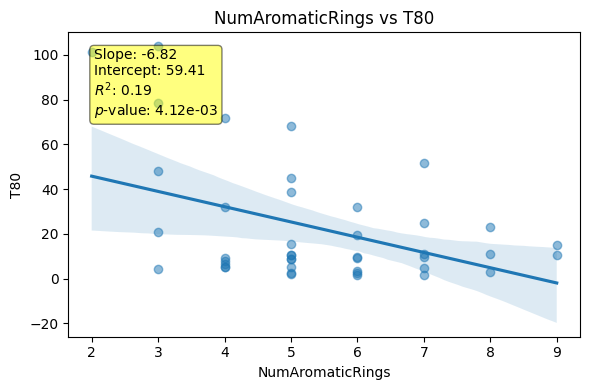

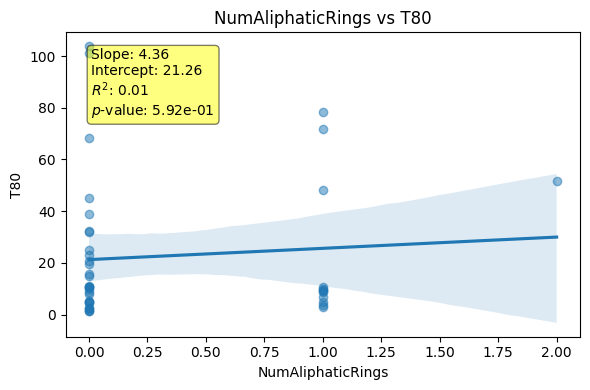

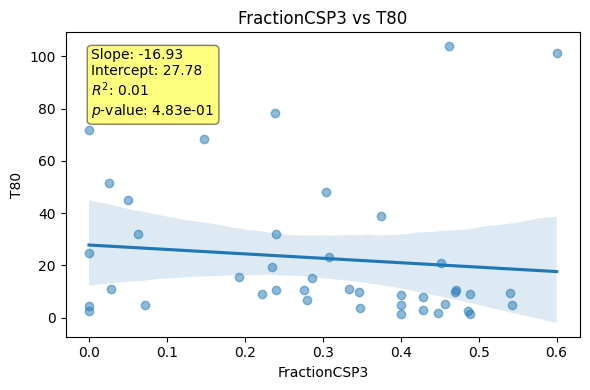

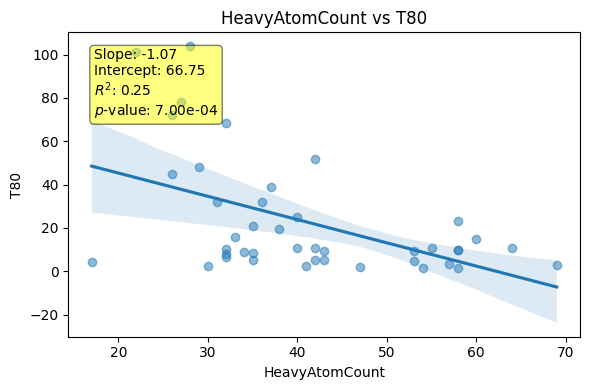

In [18]:
plot_numerical_vs_T80(train, target='T80')

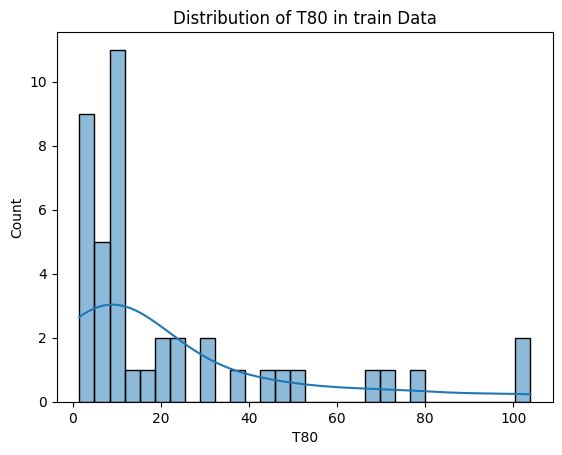

In [19]:
sns.histplot(train['T80'], kde = True, bins=30)
plt.title('Distribution of T80 in train Data')
plt.show()

In [20]:
train['T80'].describe()

count     42.000000
mean      22.710476
std       26.896407
min        1.500000
25%        5.085000
50%       10.485000
75%       30.182500
max      103.860000
Name: T80, dtype: float64

In [21]:
categorical_columns = train.select_dtypes(include=['object', 'category']).columns

# Print categorical columns
print(categorical_columns)

Index(['Smiles', 'mol'], dtype='object')


Only Smiles, and mol - remaining all are numerical columns. 

In [22]:
train.columns

Index(['T80', 'Smiles', 'Mass', 'HAcceptors', 'HDonors', 'LogP', 'Asphericity',
       'Rg', 'TPSA', 'RingCount',
       ...
       'SDOS5.4', 'mol', 'Fsp3', 'BertzCT', 'Chi0', 'Chi1', 'NumAromaticRings',
       'NumAliphaticRings', 'FractionCSP3', 'HeavyAtomCount'],
      dtype='object', length=154)

# Machine Learning Model to predict T80

In [23]:
# Drop Columns:

train.drop(['Smiles', 'mol'], axis =1, inplace =True)
test.drop(['Smiles', 'mol'], axis =1, inplace =True)

In [24]:
target = "T80"
X = train.drop(columns= target)


y = train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
train.shape

(42, 152)

In [26]:
X_train.shape

(33, 151)

In [27]:


# Define a dictionary of candidate regressors
regressors = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "Lasso": Lasso(alpha=0.1, max_iter=10000, random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, random_state=42)
}

results = {}

print("Evaluating regressors:")

# Iterate through each regressor
for name, reg in regressors.items():
    # Create a pipeline to scale features and fit the regressor
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', reg)
    ])
    
    # Perform 5-fold cross validation on training data (scoring returns negative MSE)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.mean(np.sqrt(-cv_scores))
    
    # Fit the pipeline on the entire training data and predict on the test set
    pipeline.fit(X_train, y_train)
    test_preds = pipeline.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    
    results[name] = {"CV_RMSE": cv_rmse, "Test_RMSE": test_rmse}
    print(f"{name}: CV RMSE = {cv_rmse:.4f}, Test RMSE = {test_rmse:.4f}")

# Select the best regressor based on test RMSE
best_regressor_name = min(results, key=lambda x: results[x]["Test_RMSE"])
best_metrics = results[best_regressor_name]
print("\nBest regressor based on test RMSE:")
print(f"{best_regressor_name}: Test RMSE = {best_metrics['Test_RMSE']:.4f}, CV RMSE = {best_metrics['CV_RMSE']:.4f}")


Evaluating regressors:
LinearRegression: CV RMSE = 26.2989, Test RMSE = 35.3739
Ridge: CV RMSE = 26.0240, Test RMSE = 33.7265
Lasso: CV RMSE = 26.7479, Test RMSE = 42.3673
RandomForest: CV RMSE = 19.6425, Test RMSE = 18.1691
GradientBoosting: CV RMSE = 22.6781, Test RMSE = 20.9734
XGBoost: CV RMSE = 22.5010, Test RMSE = 16.8038

Best regressor based on test RMSE:
XGBoost: Test RMSE = 16.8038, CV RMSE = 22.5010


In [28]:
# Define the final XGBoost model with the optimal hyperparameters
final_xgb = xgb.XGBRegressor(
    n_estimators=100,       # Use the best number of trees found
    max_depth=6,            # Use the best depth from your hyperparameter tuning
    learning_rate=0.1,      # Adjust based on your best validation performance
    random_state=42
)

# Re-fit the model on the entire training dataset
final_xgb.fit(X_train, y_train)

# Use the re-fitted model to predict on the test data
preds = final_xgb.predict(X_test)

# Calculate the RMSE
final_rmse = np.sqrt(mean_squared_error(y_test, preds))
print("Final XGBoost RMSE on test set:", final_rmse)

Final XGBoost RMSE on test set: 14.612856995728308


In [29]:
# # # Assuming X and y are your features and numerical target
# # kf = KFold(n_splits=10, shuffle=True, random_state=42)

# # fold_best_iterations = []
# # oof_train_rmse = []
# # oof_val_rmse = []

# # # Loop through folds and use early stopping to capture the optimal boosting rounds
# # for fold, (train_index, val_index) in enumerate(kf.split(X), start=1):
# #     X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
# #     y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
    
# #     # Define the XGBoost regressor with early stopping enabled
# #     model = XGBRegressor(
# #         n_estimators=1000,
# #         learning_rate=0.03,
# #         max_depth=10,
# #         min_child_weight=4,
# #         colsample_bytree=0.66,
# #         subsample=0.9,
# #         gamma=1.6,
# #         reg_alpha=5.5,
# #         reg_lambda=8,
# #         eval_metric="rmse",
# #         early_stopping_rounds=100,
# #         random_state=42,
# #         tree_method="hist",
# #         verbosity=0
#     )
    
#     # Fit the model using the validation fold for early stopping
#     model.fit(
#         X_train_fold, y_train_fold,
#         eval_set=[(X_val_fold, y_val_fold)],
#         verbose=False
#     )
    
#     # Record the best iteration from early stopping
#     best_iter = model.best_iteration
#     fold_best_iterations.append(best_iter)
    
#     # Compute RMSE on training and validation folds
#     train_rmse = np.sqrt(mean_squared_error(y_train_fold, model.predict(X_train_fold)))
#     val_rmse = np.sqrt(mean_squared_error(y_val_fold, model.predict(X_val_fold)))
#     oof_train_rmse.append(train_rmse)
#     oof_val_rmse.append(val_rmse)
    
#     print(f"Fold {fold}: Best Iteration = {best_iter}, Train RMSE = {train_rmse:.4f}, Val RMSE = {val_rmse:.4f}")

# # Calculate the mean best iteration from all folds
# mean_best_iter = int(np.mean(fold_best_iterations))
# print(f"\nMean Best Iteration from CV: {mean_best_iter}")

# # Optionally, you can also review average RMSEs across folds:
# print(f"Average Train RMSE: {np.mean(oof_train_rmse):.4f}")
# print(f"Average Validation RMSE: {np.mean(oof_val_rmse):.4f}")

# # Retrain final model on the entire dataset using the average best iteration
# final_model = XGBRegressor(
#     n_estimators=mean_best_iter,
#     learning_rate=0.03,
#     max_depth=10,
#     min_child_weight=4,
#     colsample_bytree=0.66,
#     subsample=0.9,
#     gamma=1.6,
#     reg_alpha=5.5,
#     reg_lambda=8,
#     eval_metric="rmse",
#     random_state=42,
#     tree_method="hist",
#     verbosity=0
# )

# final_model.fit(X_train, y_train)



# SHAP Features

In [30]:
test.shape

(9, 151)

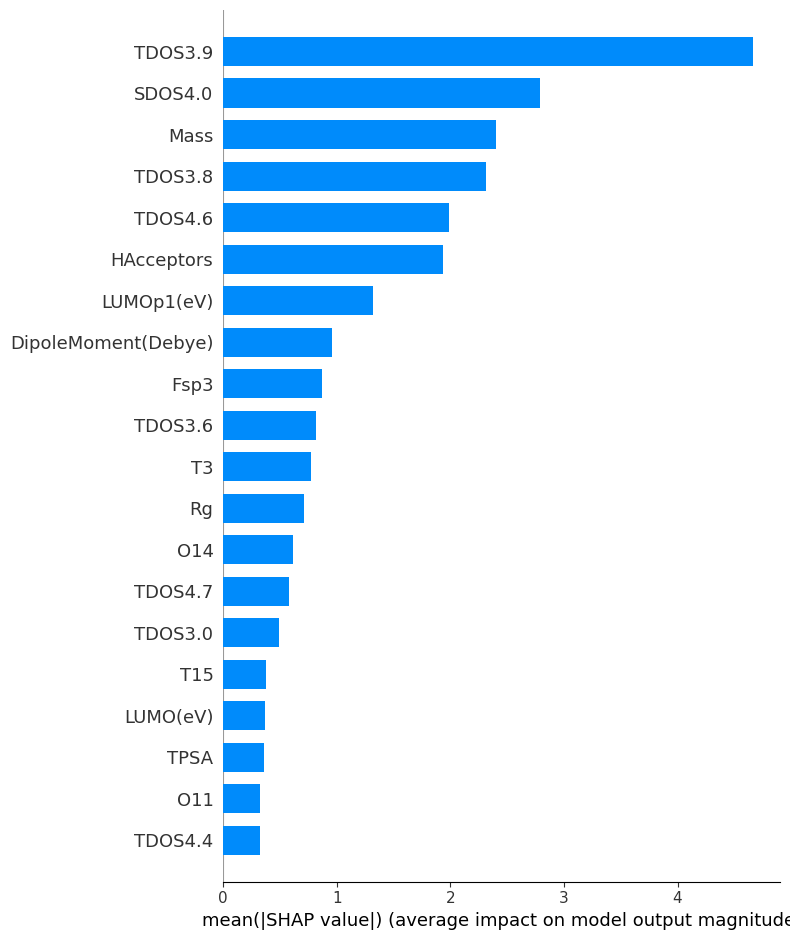

In [31]:
# Initialize the SHAP explainer

explainer = shap.TreeExplainer(final_xgb)
shap_values = explainer(X_test) 

#  Visualize the SHAP summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [32]:
#test_filtered = test[selected_features]

# Final Prediction

In [33]:
test_pred = final_xgb.predict(test)


submission = pd.DataFrame({'Batch_ID': test.index, 'T80': test_pred})
submission.to_csv('/kaggle/working/submission.csv', index=False)
display(submission)

Batch_ID        T80
0  Test-01  47.543488
1  Test-02  22.303553
2  Test-03  43.483482
3  Test-04  26.209471
4  Test-05  32.754288
5  Test-06  69.635818
6  Test-07  59.014641
7  Test-08   4.408181
8  Test-09  20.755760